In [25]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
from datetime import datetime
import subprocess

pd.set_option("display.max_columns",30)

In [26]:
def circular_mean(series):
    """
    Calculate the mean direction for circular data (e.g., wind direction).
    """
    radians = np.deg2rad(series.dropna())
    sin_mean = np.nanmean(np.sin(radians))
    cos_mean = np.nanmean(np.cos(radians))
    mean_angle = np.arctan2(sin_mean, cos_mean)
    mean_angle_deg = np.rad2deg(mean_angle)
    if mean_angle_deg < 0:
        mean_angle_deg += 360
    return mean_angle_deg

def custom_agg(series, var_name):
    if series.isna().sum() > 20:
        return np.nan
    if var_name != 'tipping' and series.nunique() <= 3:
        return np.nan

    if var_name == 'tipping':
        return series.sum()
    elif var_name == 'wind_speed':
        return series.mean()
    elif var_name == 'wind_dir':
        return circular_mean(series)
    else:
        return series.median()


aggregation_dict = {'bmp180_temp': "mean",
                    'bmp180_pres': "mean",
                    'bmp180_slp': "mean",
                    'bmp180_alt': "mean",
                    'bmp280_temp': "mean",
                    'bmp280_pres': "mean",
                    'bmp280_slp': "mean",
                    'bmp280_alt': "mean",
                    'bme_temp': "mean",
                    'bme_pres': "mean",
                    'bme_slp': "mean",
                    'bme_alt': "mean",
                    'bme_hum': "mean",
                    'htu_temp': "mean",
                    'htu_hum': "mean",
                    'mcp9808': "mean",
                    'tipping': "sum",
                    'vis_light': "mean",
                    'ir_light': "mean",
                    'uv_light': "mean",
                    'wind_dir': "mean",
                    'wind_speed': "mean"}

# Apply the custom aggregation
def apply_aggregation(df, aggregation_dict):
    df["mcp9808"] = df['mcp9808'].replace(0.0, np.nan)
    resampled_df = df.resample('h')
    aggregated_df = pd.DataFrame()
    for var_name, agg_method in aggregation_dict.items():
        if var_name == 'wind_dir':
            aggregated_df[var_name] = resampled_df[var_name].apply(lambda x: custom_agg(x, var_name))
        else:
            aggregated_df[var_name] = resampled_df[var_name].agg(agg_method)
    return aggregated_df



In [27]:
def rename_variables(ds):
    variable_mapping = {
        'var167': 't2m',      # 2 metre temperature
        'var228': 'tp',       # Total precipitation
        'var165': 'u10',      # 10 metre U wind component
        'var166': 'v10',      # 10 metre V wind component
        # Add other mappings as needed
    }
    variables_to_rename = {var: new_var for var, new_var in variable_mapping.items() if var in ds.variables}
    ds = ds.rename(variables_to_rename)
    return ds

def scale_variables(ds):
    ds["t2m"].values = ds["t2m"].values - 273.15
    ds["tp"].values = ds["tp"].values * 1000
    u10 = ds['u10']
    v10 = ds['v10']
    wind_speed = np.sqrt(u10 ** 2 + v10 ** 2)
    ds['wind_speed'] = wind_speed
    return ds

def convert_grib_to_nc( source_path):
    nc_copied_path = "converted_" + source_path 
    cdo_command = f"cdo -f nc copy {(source_path)} {nc_copied_path}"
    subprocess.run(cdo_command, shell=True, check=True)
    assert os.path.exists(nc_copied_path), "Conversion failed"

    # Open the NetCDF file and rename variables
    ds = xr.open_dataset(nc_copied_path)
    ds = rename_variables(ds)
    ds = scale_variables(ds)
    ds.to_netcdf(nc_copied_path)

In [28]:
def plot_event_comparison(event_time, 
                          hourly_df, 
                          minutely_df, 
                          era5_ds, 
                          variable_hourly, 
                          variable_minute, 
                          era5_variable, 
                          lat, 
                          lon, 
                          time_window=pd.Timedelta(hours=6),
                          same_y_axis=False,
                          title_suffix="",
                          save_fig=False,
                          save_path=None):
    """
    Plots a comparison between hourly and minutely measurements alongside ERA5 data for a specified event.

    Parameters:
    -----------
    event_time : pd.Timestamp
        The timestamp of the event to analyze.

    hourly_df : pd.DataFrame
        DataFrame containing hourly measurements with a DateTime index.

    minutely_df : pd.DataFrame
        DataFrame containing minutely measurements with a DateTime index.

    era5_ds : xarray.Dataset
        Xarray Dataset containing ERA5 data.

    variable_hourly : str
        Column name in `hourly_df` for the hourly measurement (e.g., "mcp9808", "tipping").

    variable_minute : str
        Column name in `minutely_df` for the minutely measurement (e.g., "mcp9808", "tipping").

    era5_variable : str
        Variable name in `era5_ds` for ERA5 data (e.g., "t2m", "tp").

    lat : float
        Latitude for ERA5 data extraction.

    lon : float
        Longitude for ERA5 data extraction.

    time_window : pd.Timedelta, optional
        Duration before and after the event to include in the analysis. Default is 6 hours.

    same_y_axis : bool, optional
        If True, plots all measurements on the same y-axis. If False, uses separate y-axes. Default is False.

    title_suffix : str, optional
        Additional string to append to the plot title. Useful for distinguishing between events. Default is "".

    save_fig : bool, optional
        If True, saves the figure to `save_path`. Default is False.

    save_path : str, optional
        File path to save the figure. Required if `save_fig` is True.

    Returns:
    --------
    None
    """
    # Define the time window
    start_time = event_time - time_window
    end_time = event_time + time_window

    # Filter the DataFrames within the time window
    filtered_hourly = hourly_df.loc[start_time:end_time]
    filtered_minutely = minutely_df.loc[start_time:end_time]

    # Extract ERA5 data for the specified location and time window
    era5_data = era5_ds[era5_variable].sel(lat=lat, lon=lon, method='nearest')
    era5_filtered = era5_data.sel(time=slice(start_time, end_time))
    era5_pd = era5_filtered.to_pandas()

    # Ensure that the indices align for plotting
    # If not, consider resampling or interpolating
    # For simplicity, we'll assume they are aligned or handle missing data gracefully

    # Start plotting
    plt.figure(figsize=(16, 8))

    if variable_hourly == "tipping": 
        unit = "mm"
    elif variable_hourly == "wind_speed":
        unit = "m/s"
    else:
        unit = "°C"

    if same_y_axis:
        # Plot all data on the same y-axis
        plt.plot(filtered_hourly.index, filtered_hourly[variable_hourly], 
                 color='mediumblue', label=f"Hourly {variable_hourly.capitalize()}", linewidth=2, marker='x')
        plt.plot(filtered_minutely.index, filtered_minutely[variable_minute], 
                 color='orange', label=f"Minutely {variable_minute.capitalize()}", linewidth=1, marker='o', alpha=0.5, markersize=2)
        plt.plot(era5_pd.index, era5_pd.values, 
                 color='green', label=f"ERA5 {era5_variable.upper()}", linewidth=2, marker='x')

        plt.xlabel("Datetime", fontsize=12)
        plt.ylabel(f"{variable_hourly.capitalize()} in {unit}", fontsize=12)
        plt.title(f"Event: {event_time} - {title_suffix}", fontsize=14)
        plt.grid(alpha=0.7)
        plt.legend(loc="upper right", fontsize=12)
    else:
        # Create primary y-axis
        ax1 = plt.gca()
        ax1.plot(filtered_hourly.index, filtered_hourly[variable_hourly], 
                 color='mediumblue', label=f"Hourly {variable_hourly.capitalize()}", linewidth=2, marker='x')
        ax1.set_xlabel("Datetime", fontsize=12)
        ax1.set_ylabel(f"{variable_hourly.capitalize()} in {unit} (Hourly)", fontsize=12)
        ax1.tick_params(axis='y')
        ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

        # Plot minutely data on the same primary y-axis
        ax1.plot(filtered_minutely.index, filtered_minutely[variable_minute], 
                 color='orange', label=f"Minutely {variable_minute.capitalize()}", linewidth=1, marker='o', alpha=0.5, markersize=2)

        # Create secondary y-axis for ERA5 data
        ax2 = ax1.twinx()
        ax2.plot(era5_pd.index, era5_pd.values, 
                 color='green', label=f"ERA5 {era5_variable.upper()}", linewidth=2, marker='x')
        ax2.set_ylabel(f"ERA5 {era5_variable.upper()} in {unit}", fontsize=12)
        ax2.tick_params(axis='y')

        # Combine legends from both axes
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", fontsize=12)

        plt.title(f"Event: {event_time} - {title_suffix}", fontsize=14)

    # Improve x-axis date formatting
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Optionally save the figure
    if save_fig:
        if save_path is None:
            raise ValueError("save_path must be provided if save_fig is True.")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    # Display the plot
    plt.show()

# Events

## Vienna

In [70]:
convert_grib_to_nc("era5_data/era5_vienna_events.nc")


In [71]:
vienna_er5 = xr.open_dataset("converted_era5_data/era5_vienna_events.nc")
vienna_er5

<xarray.Dataset> Size: 14MB
Dimensions:     (time: 8808, lon: 9, lat: 9)
Coordinates:
  * time        (time) datetime64[ns] 70kB 2017-08-03 ... 2018-08-04T23:00:00
  * lon         (lon) float64 72B 15.36 15.61 15.86 16.11 ... 16.86 17.11 17.36
  * lat         (lat) float64 72B 49.23 48.98 48.73 48.48 ... 47.73 47.48 47.23
Data variables:
    t2m         (time, lat, lon) float32 3MB ...
    tp          (time, lat, lon) float32 3MB ...
    u10         (time, lat, lon) float32 3MB ...
    v10         (time, lat, lon) float32 3MB ...
    wind_speed  (time, lat, lon) float32 3MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Oct 22 11:45:39 2024: cdo -f nc copy era5_data/era5_vie...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [72]:
print("Highest precip. value in ERA5:",vienna_er5.tp.values.max())
print("Highest temp. value in ERA5:",vienna_er5.t2m.values.max())
print("Highest wind speed value in ERA5:",vienna_er5.wind_speed.values.max())

Highest precip. value in ERA5: 10.334253
Highest temp. value in ERA5: 38.113434
Highest wind speed value in ERA5: 13.629203


In [73]:
vienna_processed_df = pd.read_csv("station_data_processed/vienna_hourly_processed_data.csv", index_col=0)
vienna_processed_df.index = pd.to_datetime(vienna_processed_df.index, errors='coerce')

# Apply the optimized aggregation
vienna_hourly_df = apply_aggregation(vienna_processed_df, aggregation_dict)

No high wind speed event

Precipitation: 
- 18.05.10 12/11 >354l
- 17.10.16 16 > 97l

Temperature: 
- cold: 18.03.01 03/02 <10°
- hot: 17.08.03 14/12/13 >35°

### Temperature

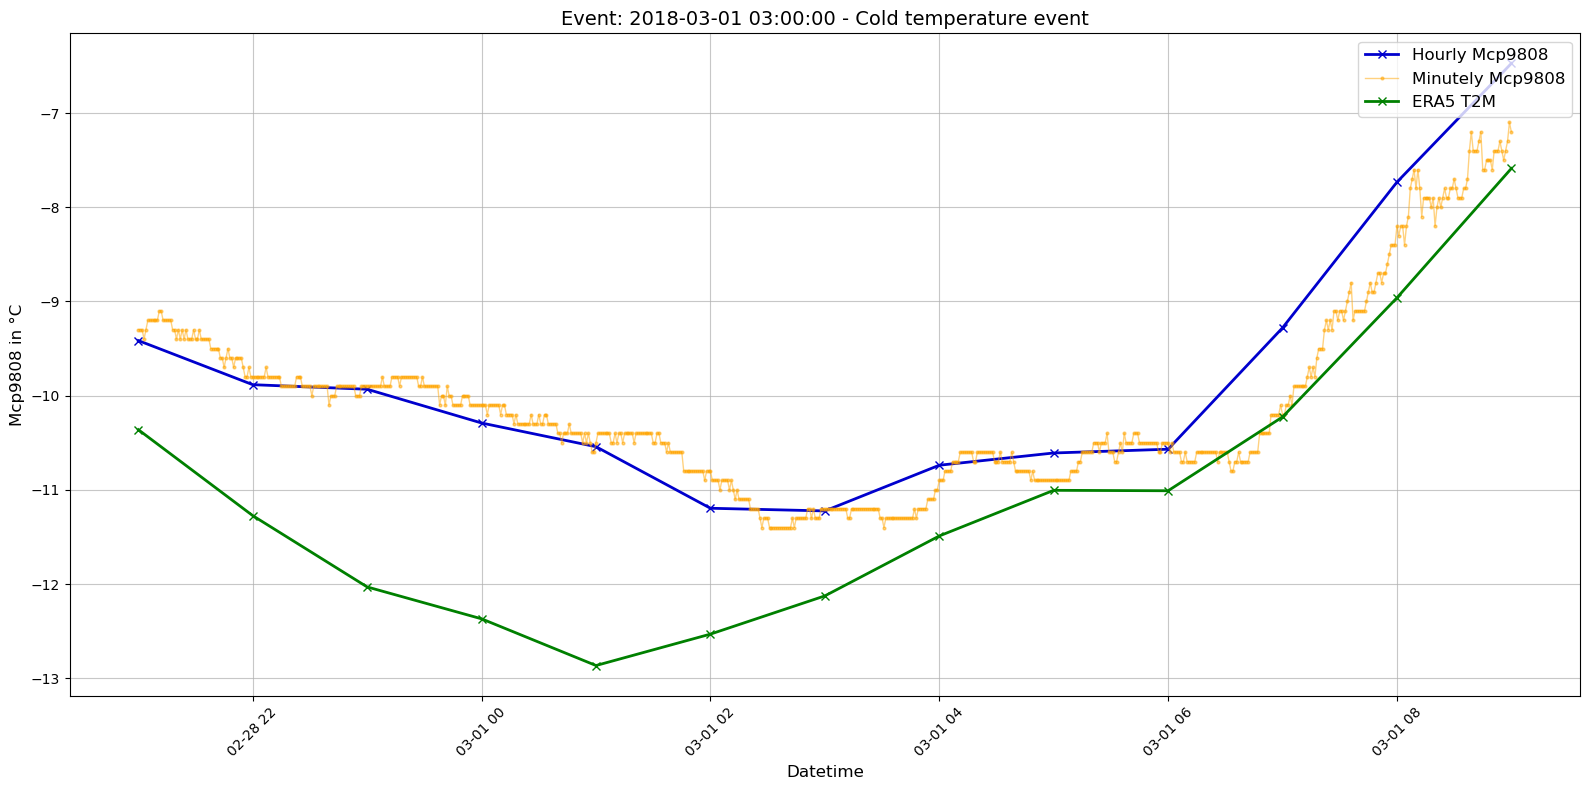

In [74]:
# Example Event 1
event_1 = pd.Timestamp("2018-03-01 03:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_processed_df,
    era5_ds=vienna_er5,
    variable_hourly="mcp9808",       # Hourly temperature
    variable_minute="mcp9808",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=48.2303 ,
    lon=16.3609,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=True,
    title_suffix="Cold temperature event",
    save_fig=False
)

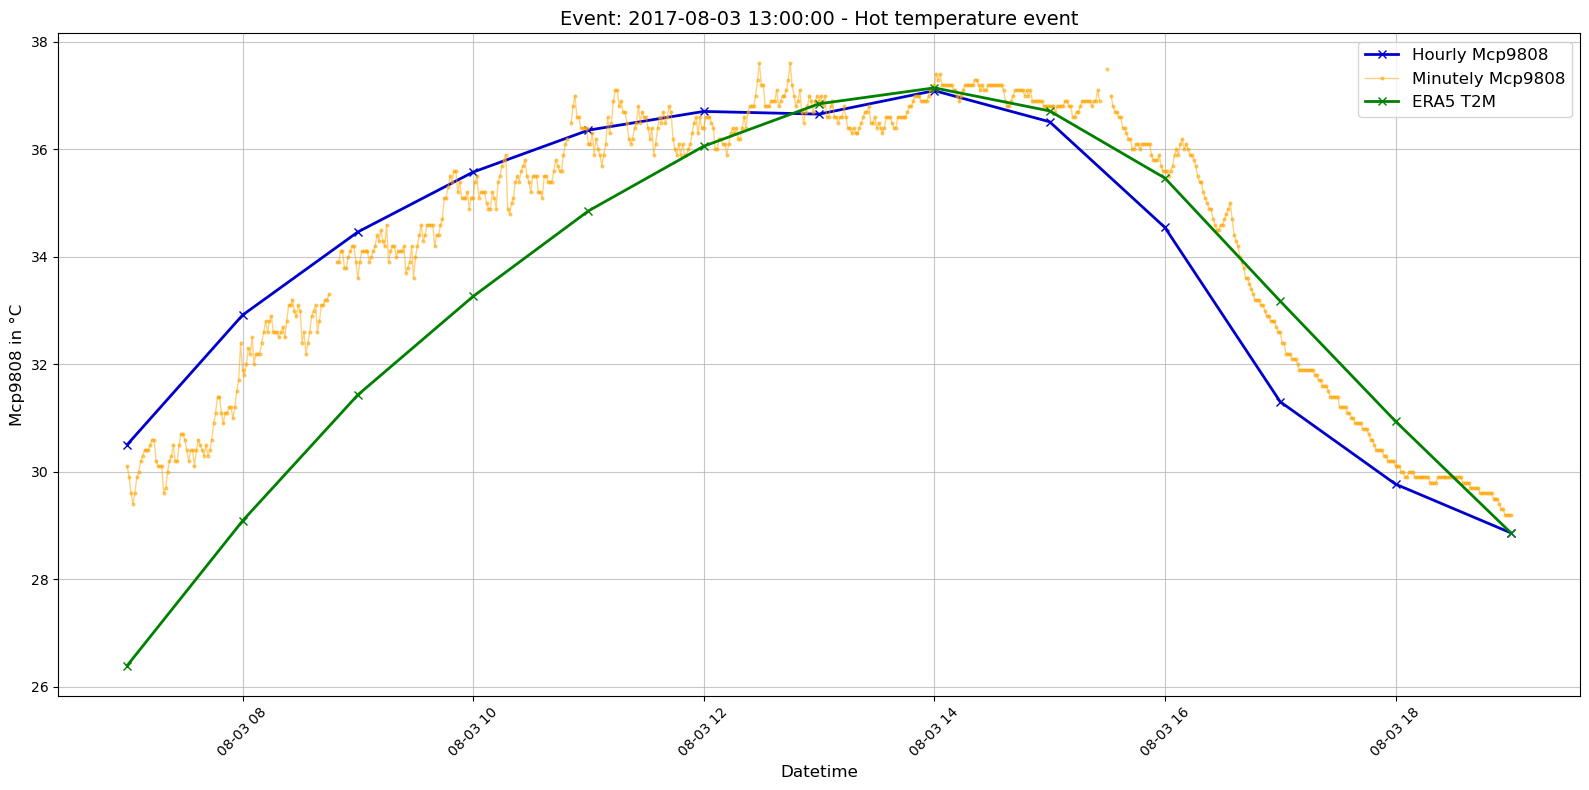

In [46]:
# Example Event 1
event_2 = pd.Timestamp("2017-08-03 13:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_2,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_processed_df,
    era5_ds=vienna_er5,
    variable_hourly="mcp9808",       # Hourly temperature
    variable_minute="mcp9808",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=48.2303 ,
    lon=16.3609,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=True,
    title_suffix="Hot temperature event",
    save_fig=False
)

### Precipitation

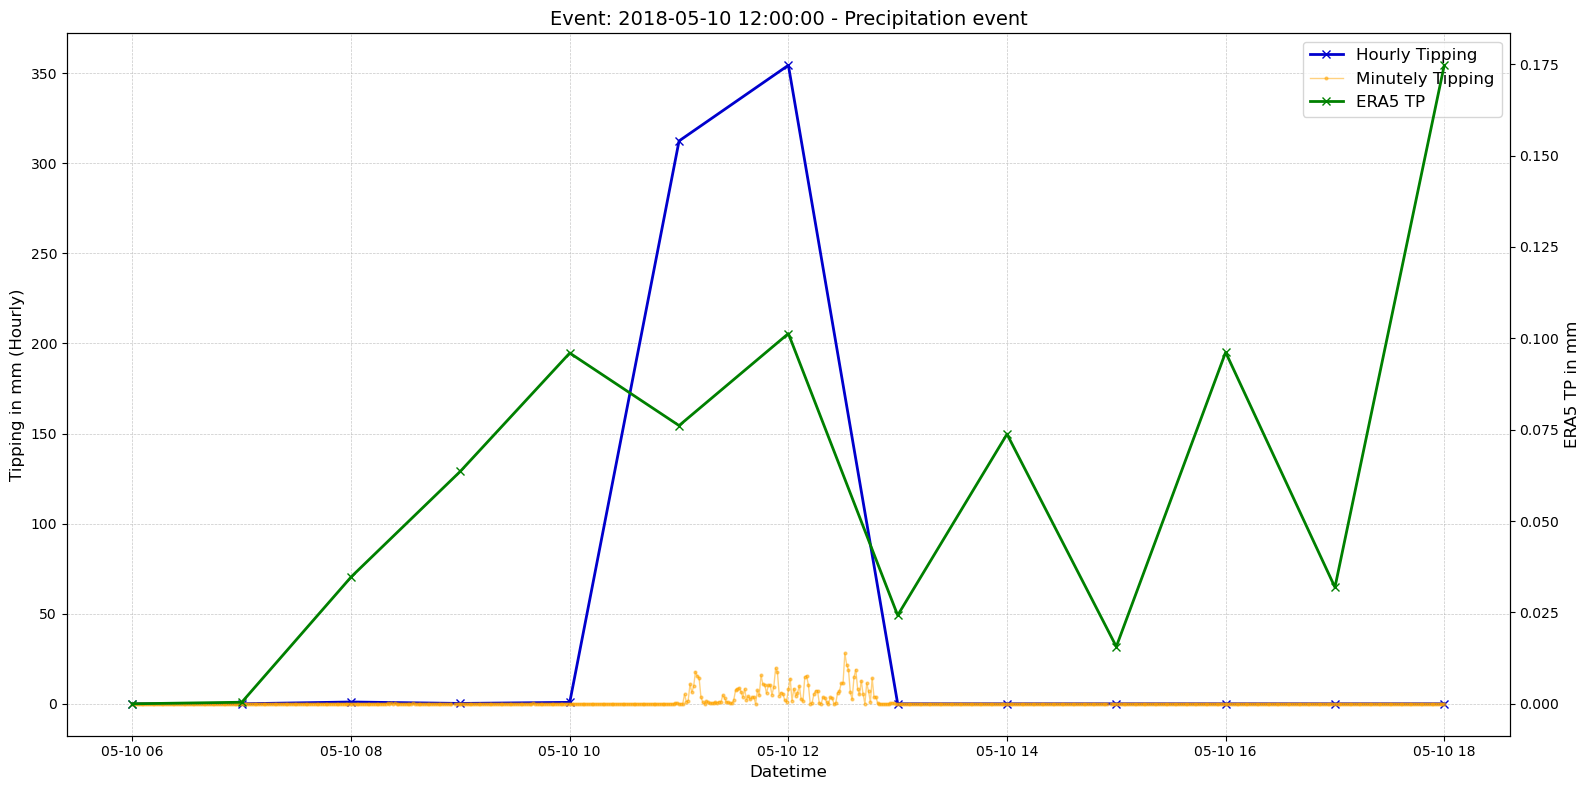

In [75]:
# Example Event 1
event_3 = pd.Timestamp("2018-05-10 12:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_processed_df,
    era5_ds=vienna_er5,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=48.2303 ,
    lon=16.3609,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=False,
    title_suffix="Precipitation event",
    save_fig=False
)

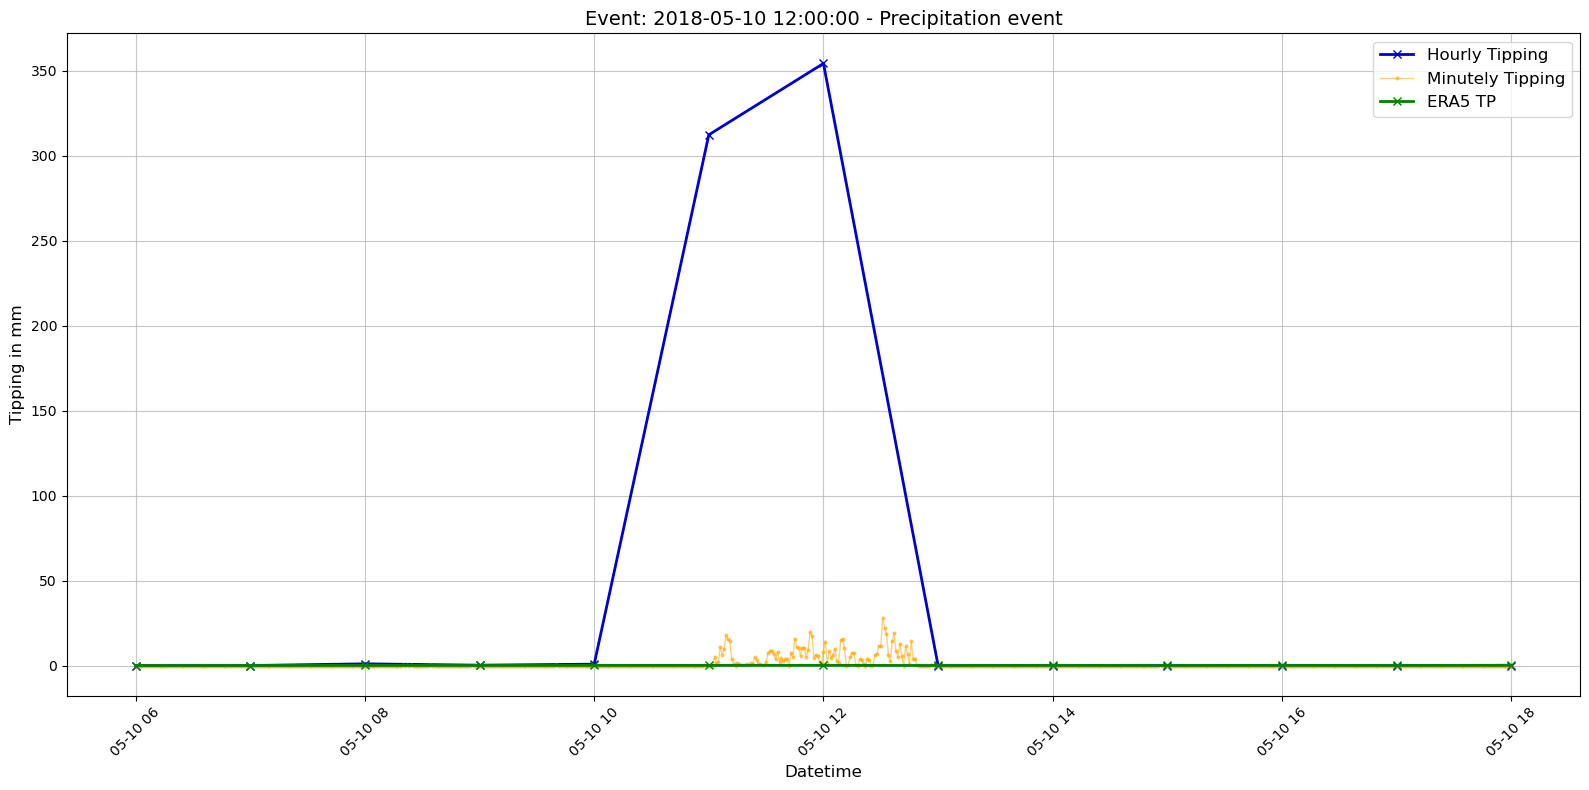

In [76]:
# Example Event 1
event_3 = pd.Timestamp("2018-05-10 12:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_processed_df,
    era5_ds=vienna_er5,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=48.2303 ,
    lon=16.3609,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=True,
    title_suffix="Precipitation event",
    save_fig=False
)

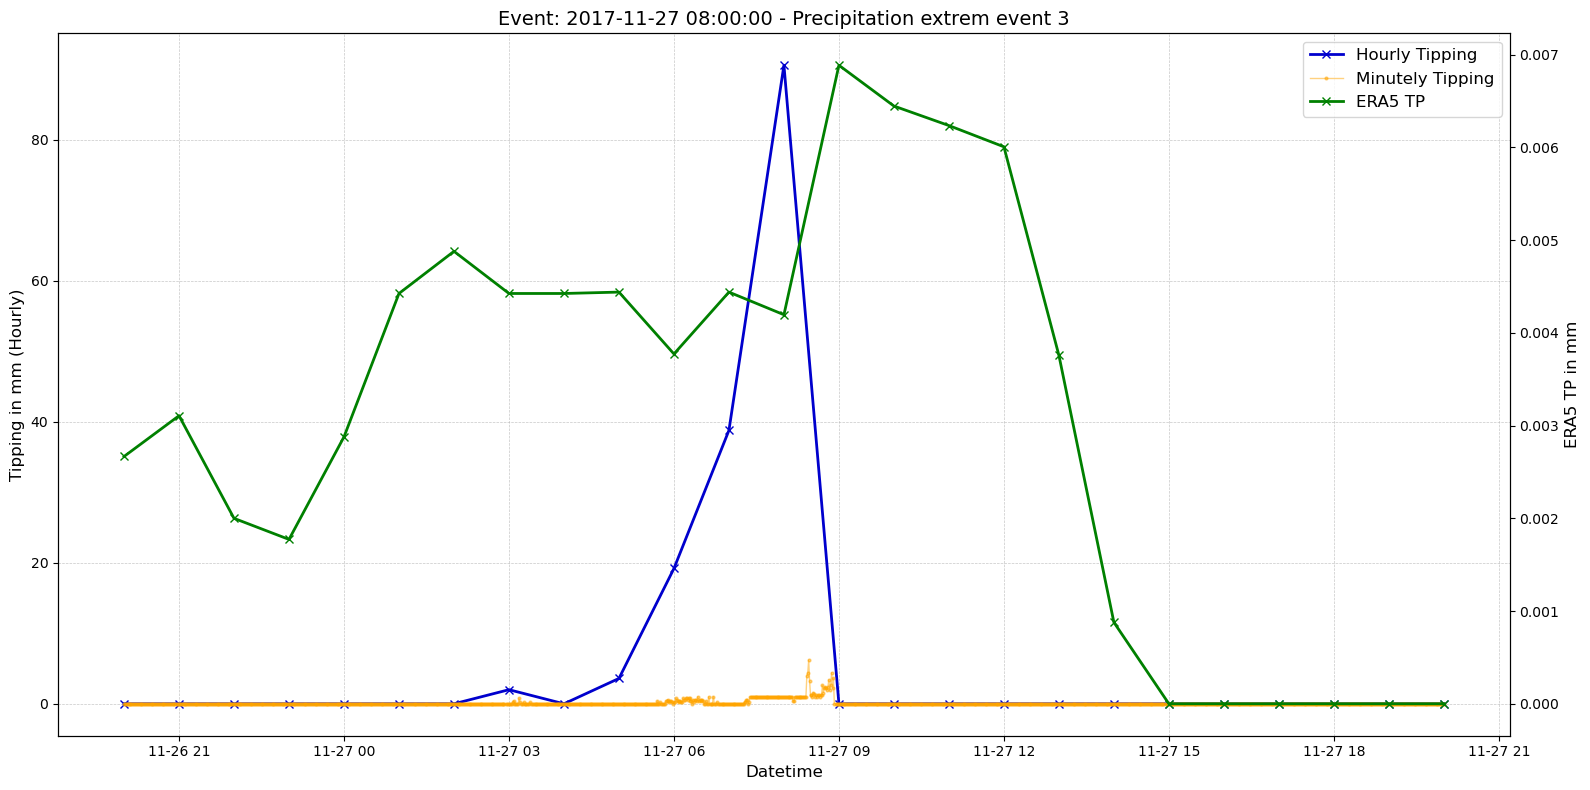

In [100]:
# Example Event 1
event_3 = pd.Timestamp("2017-11-27 08:00:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_processed_df,
    era5_ds=vienna_er5,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=False,
    title_suffix="Precipitation extrem event 3",
    save_fig=False
)

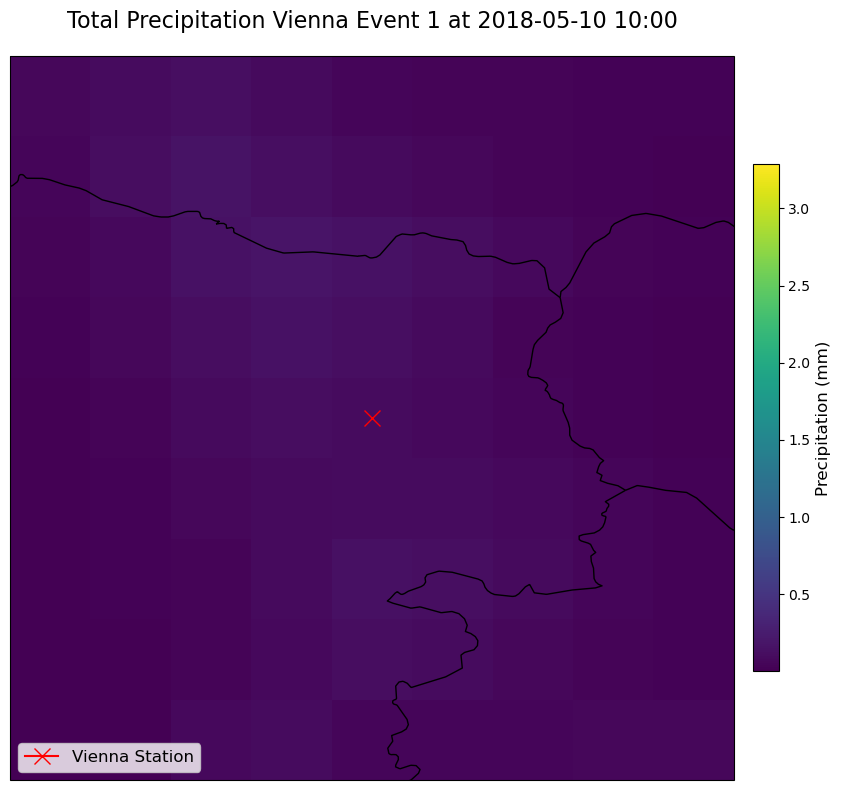

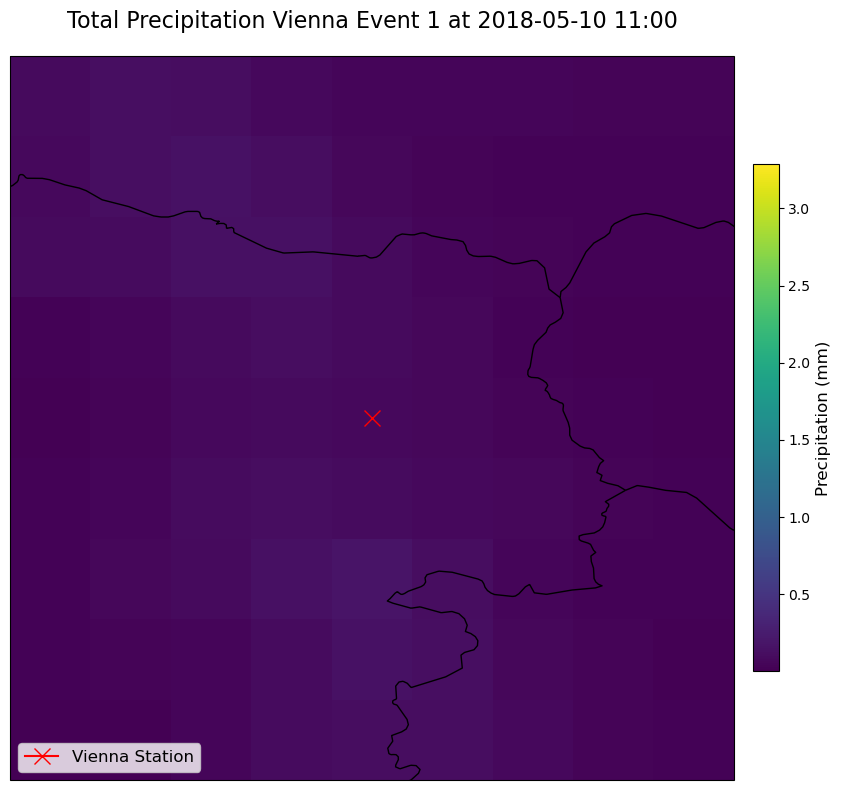

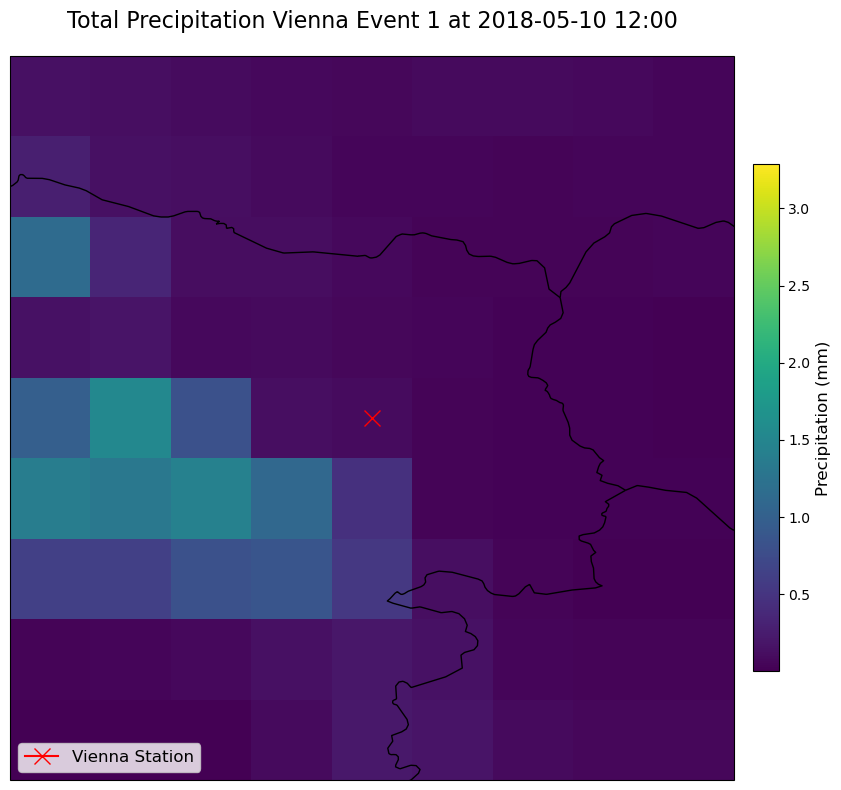

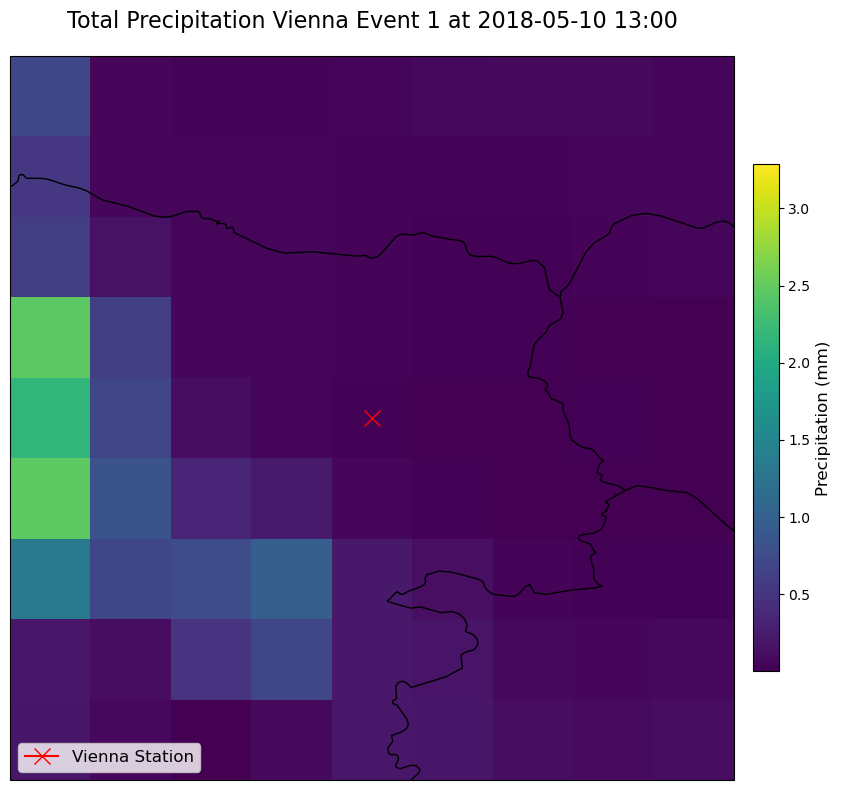

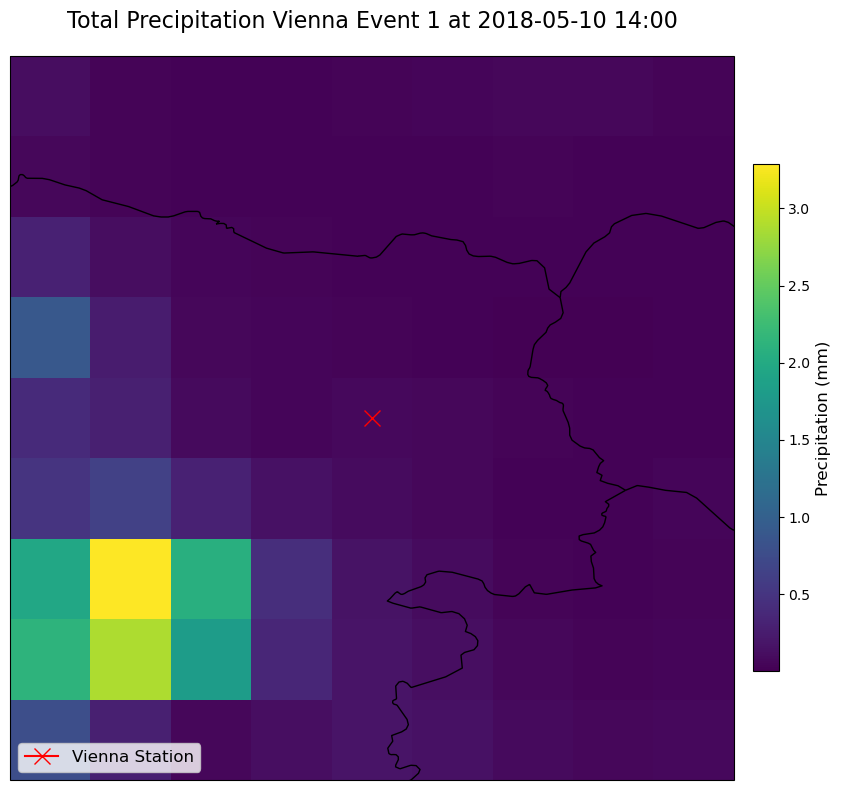

In [102]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd

# Define the variable and coordinate names
var = 'tp'
lat = vienna_er5.lat.values
lon = vienna_er5.lon.values

# Coordinates of the specific point (Vienna Station)
point_lon = 16.3609  
point_lat = 48.2303 

# Select the time range
selected_data = vienna_er5.sel(time=slice("2018-05-10 10:00", "2018-05-10 14:00"))

# Create a meshgrid for pcolormesh
Lon, Lat = np.meshgrid(lon, lat)

# Define plot parameters
cmap = 'viridis'
vmin = selected_data[var].min().item()
vmax = selected_data[var].max().item()
title_base = 'Total Precipitation Vienna Event 1'

for t in selected_data.time:
    # Create a new figure with Cartopy's PlateCarree projection
    fig, ax = plt.subplots(
        figsize=(10, 8),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    
    # Extract data for the current time step
    data = selected_data[var].sel(time=t).values
    
    # Handle missing or invalid data
    data = np.ma.masked_invalid(data)
    
    # Plot the data using pcolormesh
    pcm = ax.pcolormesh(
        Lon, Lat, data, 
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree()
    )
    
    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)

    # Plot the specific point (Vienna Station)
    ax.plot(
        point_lon, point_lat,
        marker='x', color='red', markersize=12,
        transform=ccrs.PlateCarree(),
        label='Vienna Station'
    )
    
    # Add a colorbar
    cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.02, shrink=0.7)
    cbar.set_label('Precipitation (mm)', fontsize=12)
    
    # Set title with time information
    time_str = pd.to_datetime(t.values).strftime('%Y-%m-%d %H:%M')
    plt.title(f'{title_base} at {time_str}', fontsize=16, pad=20)
    
    # Add legend for the Vienna Station marker
    ax.legend(loc='lower left', fontsize=12)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Close the figure to free memory
    plt.close(fig)




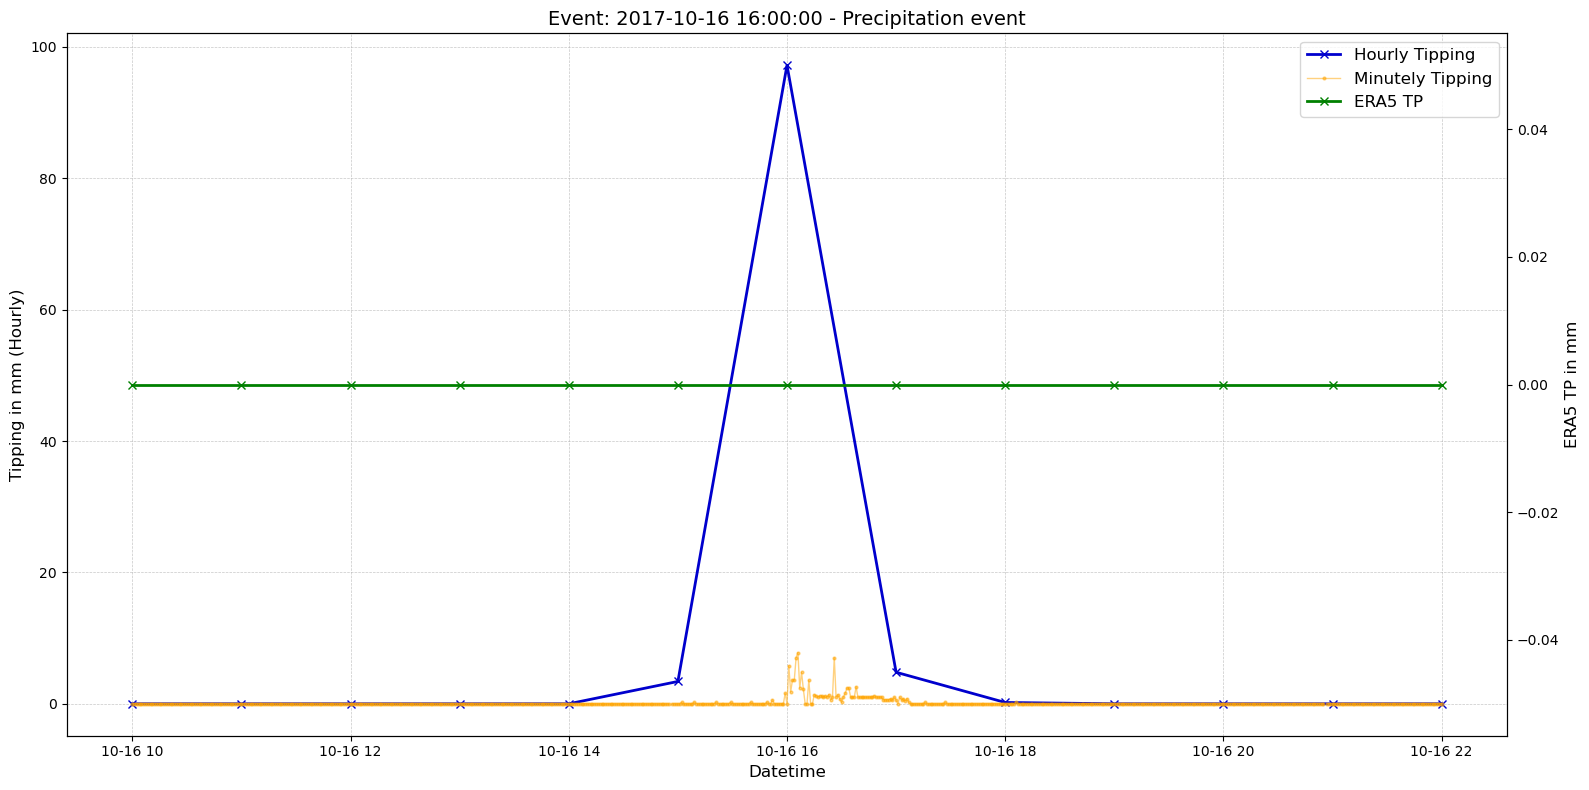

In [77]:
# Example Event 1
event_4 = pd.Timestamp("2017-10-16 16:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_4,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_processed_df,
    era5_ds=vienna_er5,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=48.2303 ,
    lon=16.3609,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=False,
    title_suffix="Precipitation event",
    save_fig=False
)

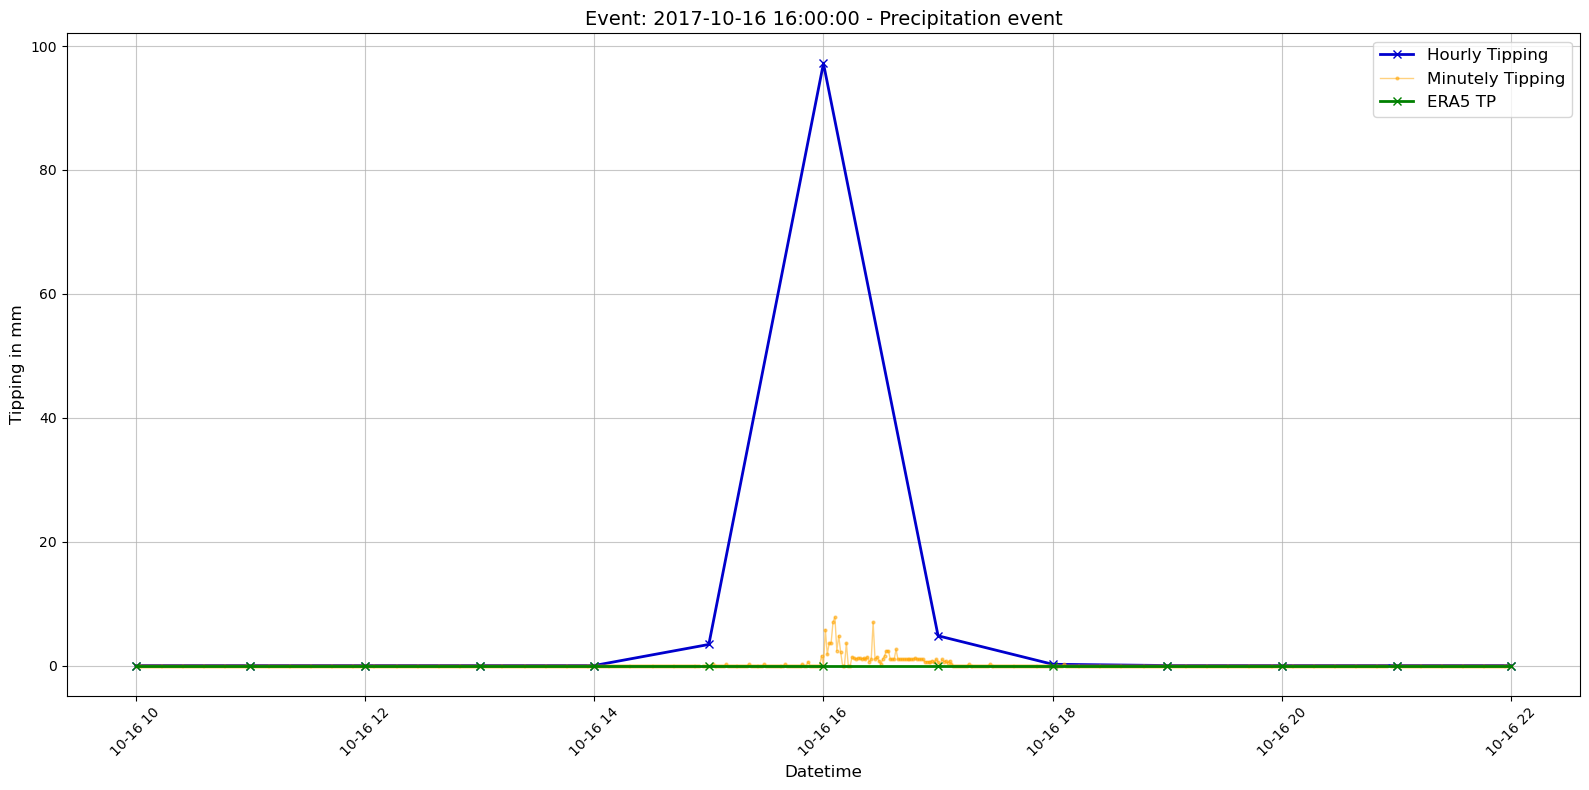

In [78]:
# Example Event 1
event_4 = pd.Timestamp("2017-10-16 16:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_4,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_processed_df,
    era5_ds=vienna_er5,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=48.2303 ,
    lon=16.3609,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=True,
    title_suffix="Precipitation event",
    save_fig=False
)

## Marshall

In [109]:
convert_grib_to_nc("era5_data/era5_marshall_events.nc")


In [121]:
marshall_er5 = xr.open_dataset("converted_era5_data/era5_marshall_events.nc")
marshall_er5

<xarray.Dataset> Size: 45MB
Dimensions:     (time: 27600, lon: 9, lat: 9)
Coordinates:
  * time        (time) datetime64[ns] 221kB 2020-02-07 ... 2023-04-01T23:00:00
  * lon         (lon) float64 72B -106.2 -105.9 -105.7 ... -104.7 -104.4 -104.2
  * lat         (lat) float64 72B 40.95 40.7 40.45 40.2 ... 39.45 39.2 38.95
Data variables:
    t2m         (time, lat, lon) float32 9MB ...
    tp          (time, lat, lon) float32 9MB ...
    u10         (time, lat, lon) float32 9MB ...
    v10         (time, lat, lon) float32 9MB ...
    wind_speed  (time, lat, lon) float32 9MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Oct 22 16:36:36 2024: cdo -f nc copy era5_data/era5_mar...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [53]:
print("Highest precip. value in ERA5:",marshall_er5.tp.values.max())
print("Highest temp. value in ERA5:",marshall_er5.t2m.values.max())
print("Highest wind speed value in ERA5:",marshall_er5.wind_speed.values.max())

Highest precip. value in ERA5: 14.425681
Highest temp. value in ERA5: 38.97696
Highest wind speed value in ERA5: 18.766888


In [55]:
marshall_processed_df = pd.read_csv("station_data_processed/marshall_hourly_processed_data.csv", index_col=0)
marshall_processed_df.index = pd.to_datetime(marshall_processed_df.index, errors='coerce')

marshall_hourly_df = pd.DataFrame()

marshall_hourly_df = apply_aggregation(marshall_processed_df, aggregation_dict)

Wind speed:
- 2018-04-17 20:00:00 >15m/s

Precipitation: 
- 20.02.08 16/17 >400l und 100l
- 21.02.19 17 > 60l

Temperature: 
- cold: 22.12.22 13/14/15 <-26°
- hot: 22.07.18 18  >35°

In [56]:
convert_grib_to_nc("era5_data/era5_marshall_events_180417.nc")
marshall_er5_180417 = xr.open_dataset("converted_era5_data/era5_marshall_events_180417.nc")


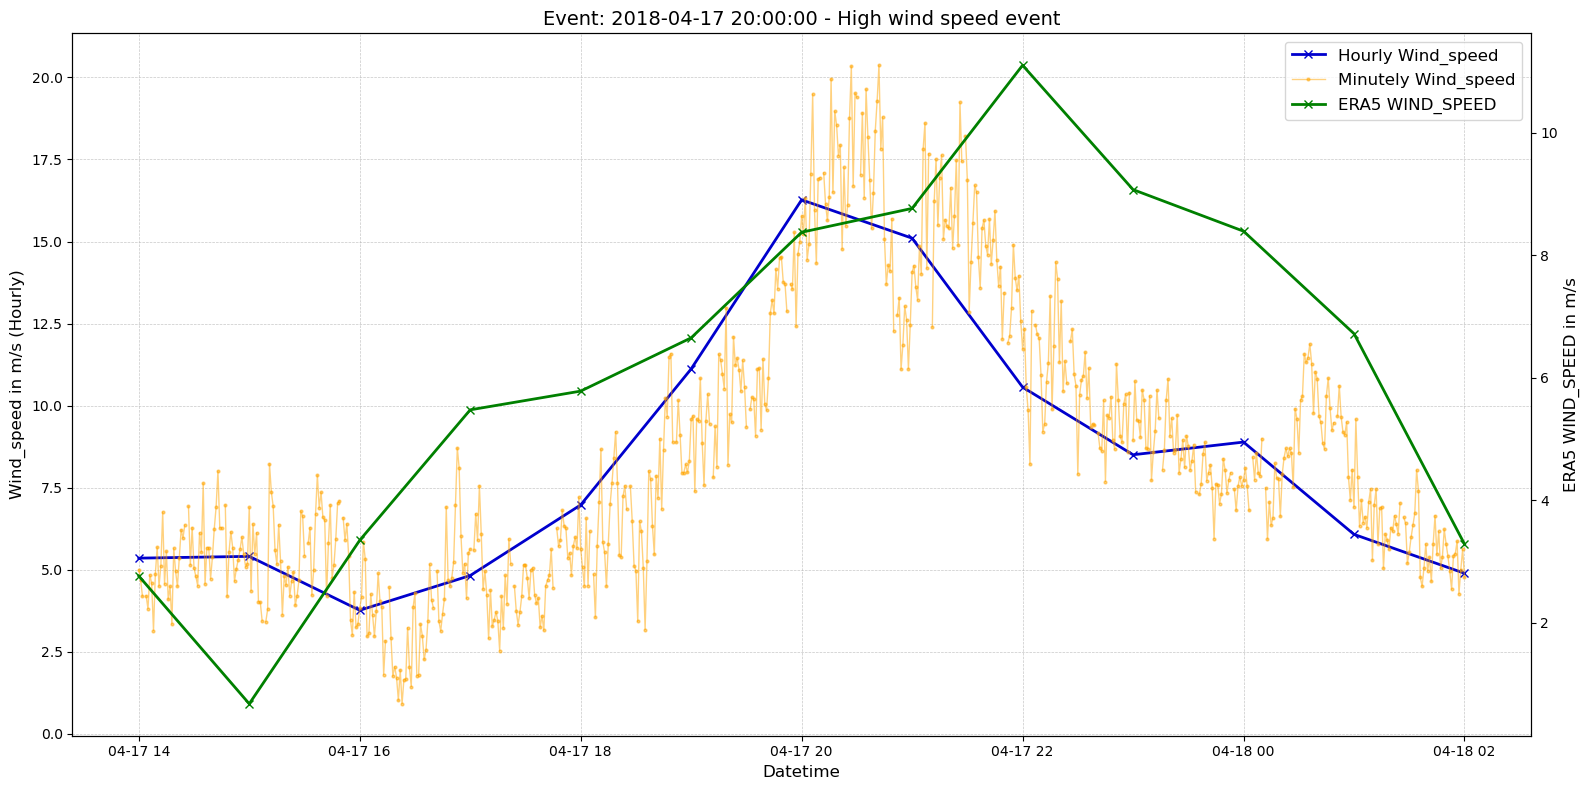

In [57]:
# Example Event 1
event_1 = pd.Timestamp("2018-04-17 20:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    era5_ds=marshall_er5_180417,
    variable_hourly="wind_speed",       # Hourly temperature
    variable_minute="wind_speed",       # Minutely temperature
    era5_variable="wind_speed",              # ERA5 2-meter temperature
    lat=39.9496 ,
    lon=-105.196,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=False,
    title_suffix="High wind speed event",
    save_fig=False
)



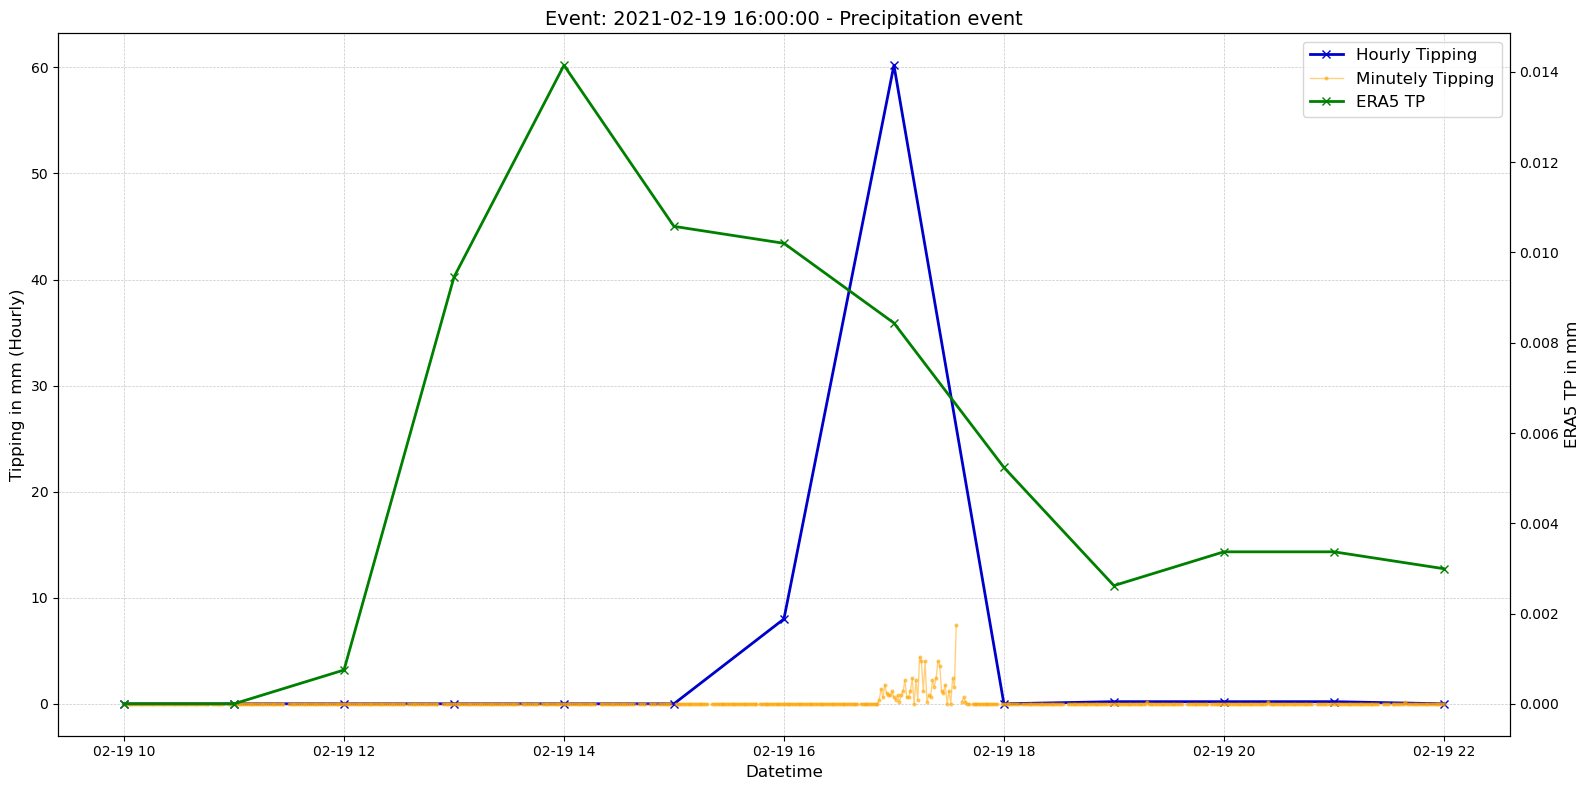

In [58]:
# Example Event 1
event_2 = pd.Timestamp("2021-02-19 16:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_2,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    era5_ds=marshall_er5,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=39.9496 ,
    lon=-105.196,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=False,
    title_suffix="Precipitation event",
    save_fig=False
)


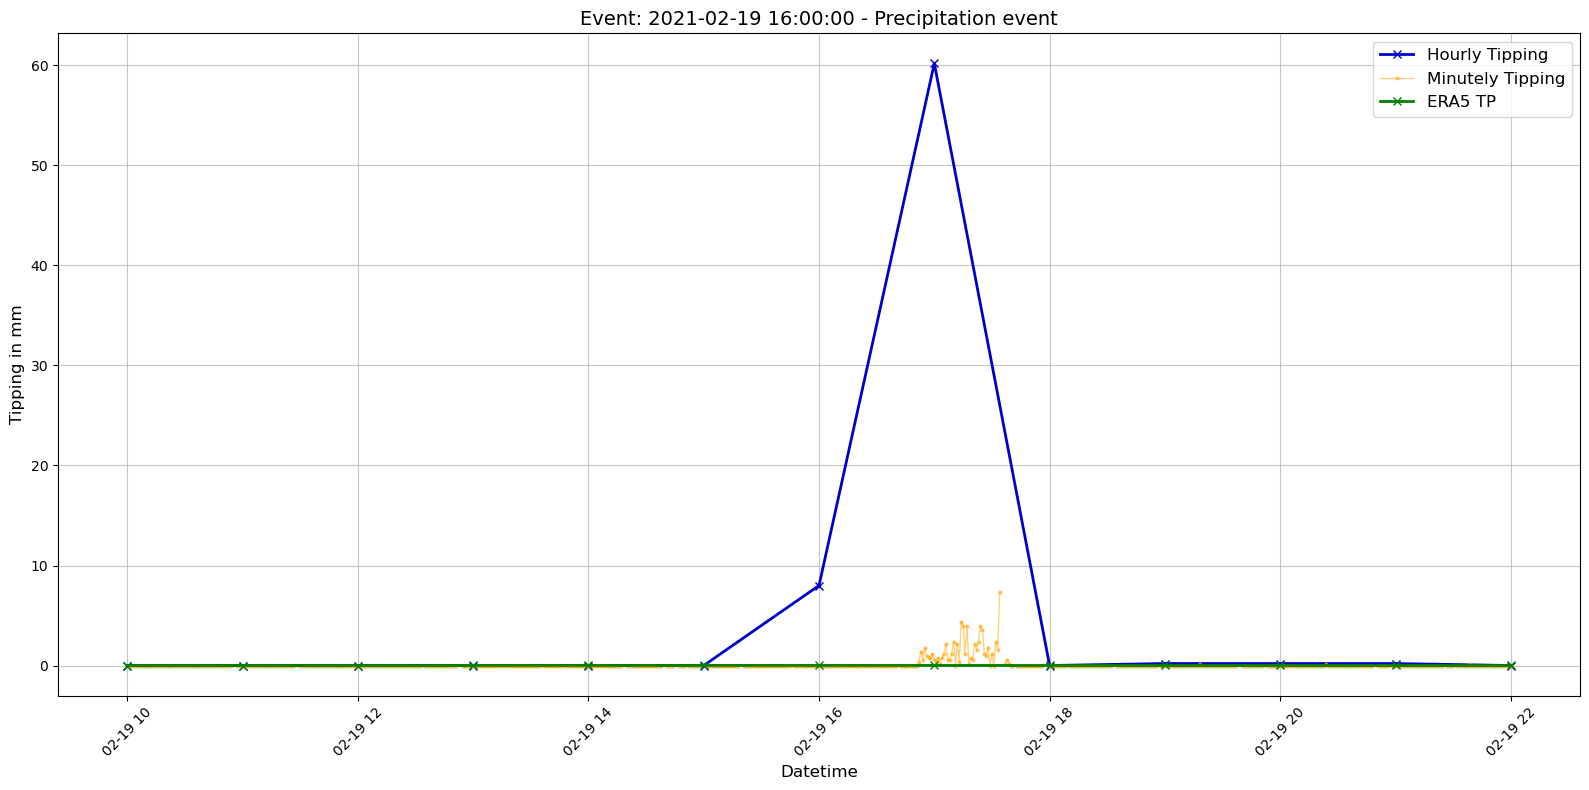

In [59]:
# Example Event 1
event_2 = pd.Timestamp("2021-02-19 16:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_2,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    era5_ds=marshall_er5,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=39.9496 ,
    lon=-105.196,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=True,
    title_suffix="Precipitation event",
    save_fig=False
)


In [104]:
mesa = xr.open_dataset("Data_mesa_site/mlab.20200208.cdf")

mesa_pd = mesa["raina"].to_pandas()
mesa_pd.max()

0.0

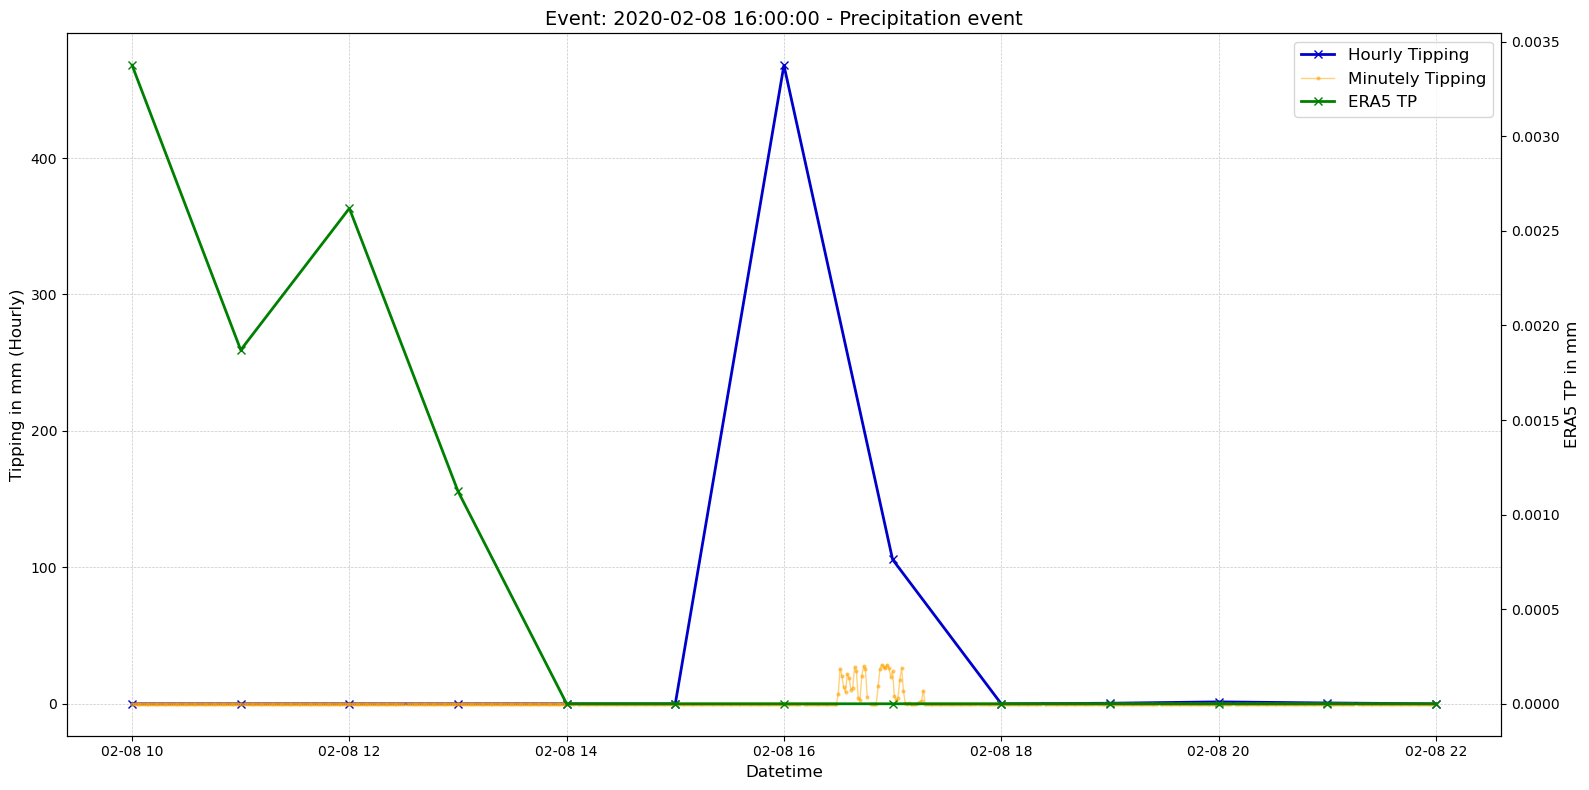

In [60]:
# Example Event 1
event_3 = pd.Timestamp("2020-02-08 16:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    era5_ds=marshall_er5,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=39.9496 ,
    lon=-105.196,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=False,
    title_suffix="Precipitation event",
    save_fig=False
)


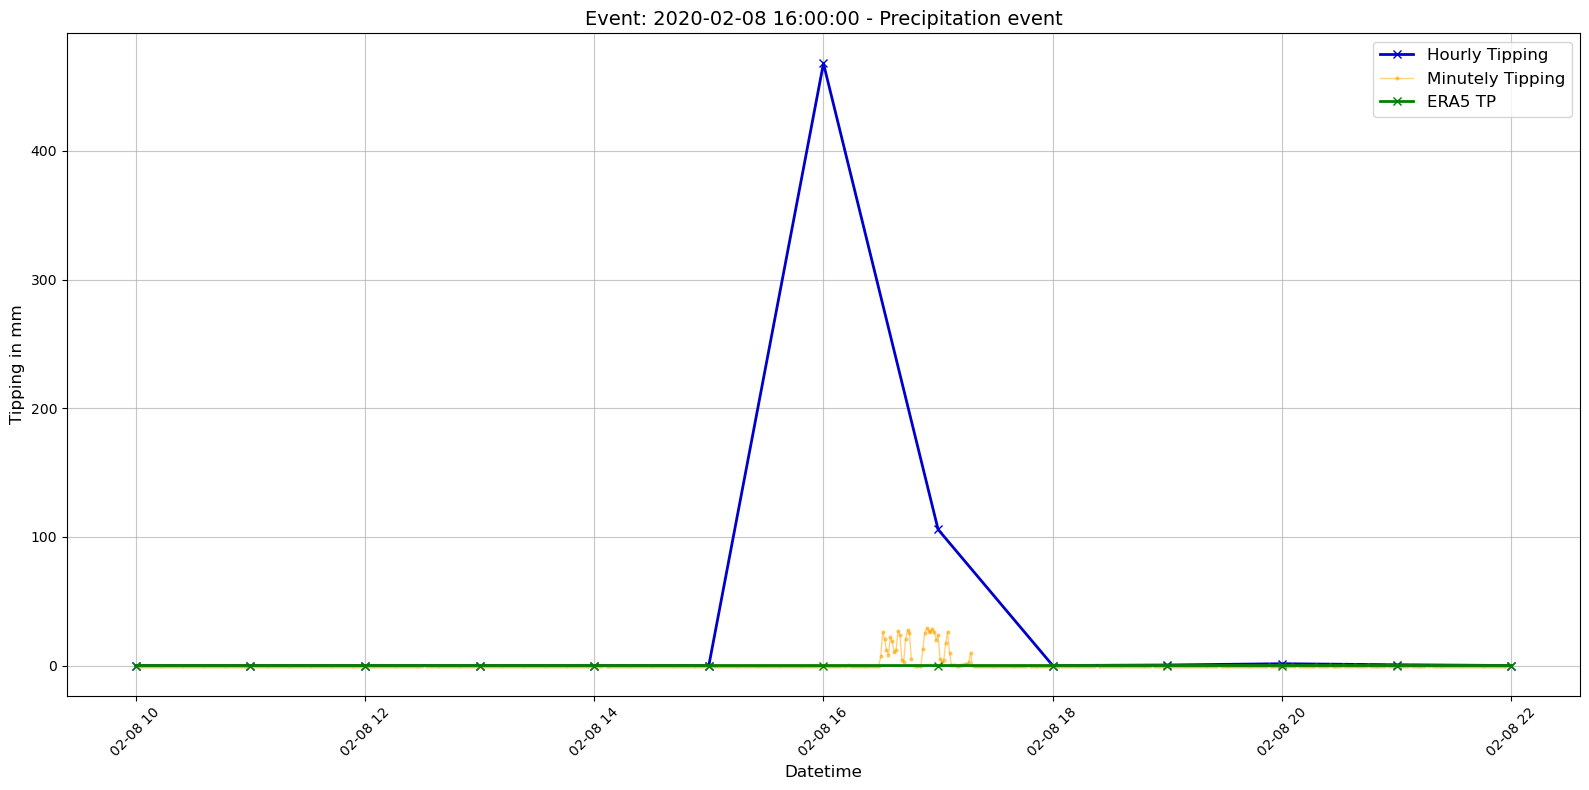

In [61]:
# Example Event 1
event_3 = pd.Timestamp("2020-02-08 16:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    era5_ds=marshall_er5,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=39.9496 ,
    lon=-105.196,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=True,
    title_suffix="Precipitation event",
    save_fig=False
)

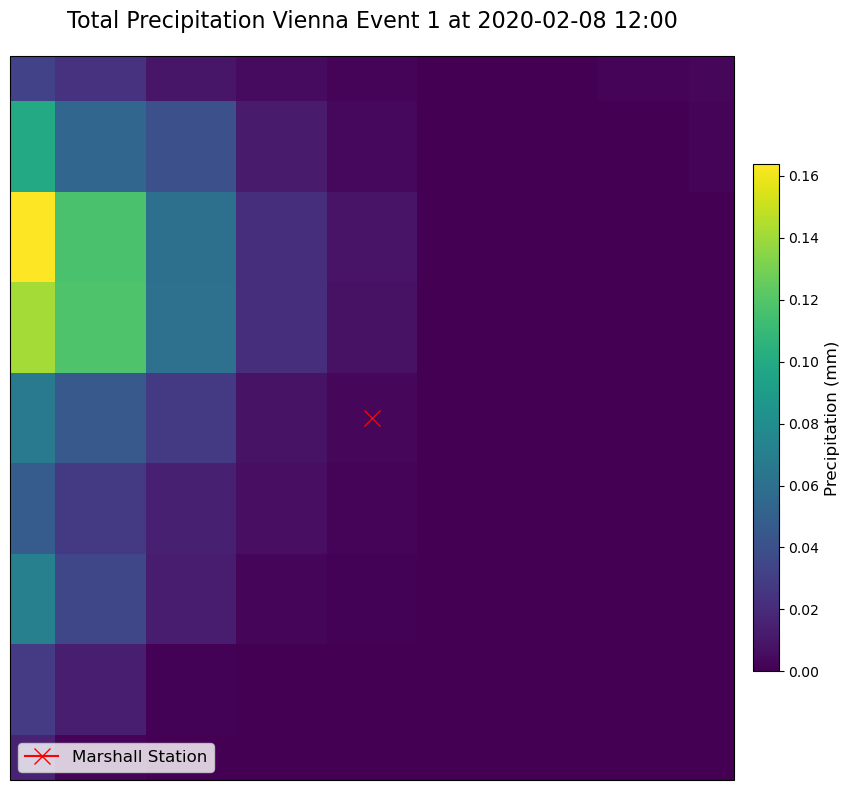

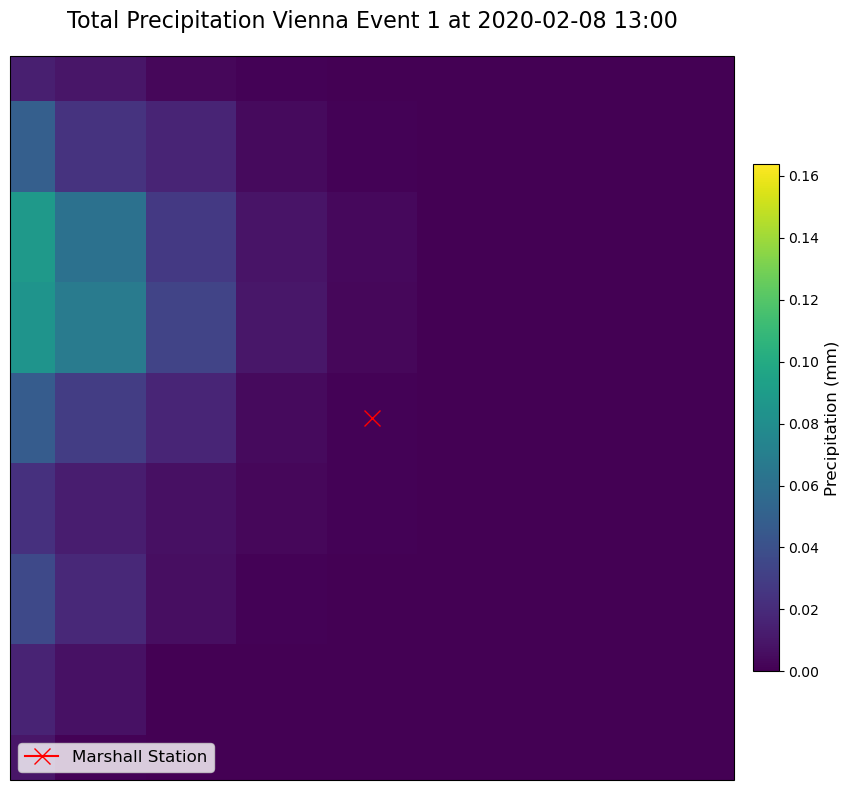

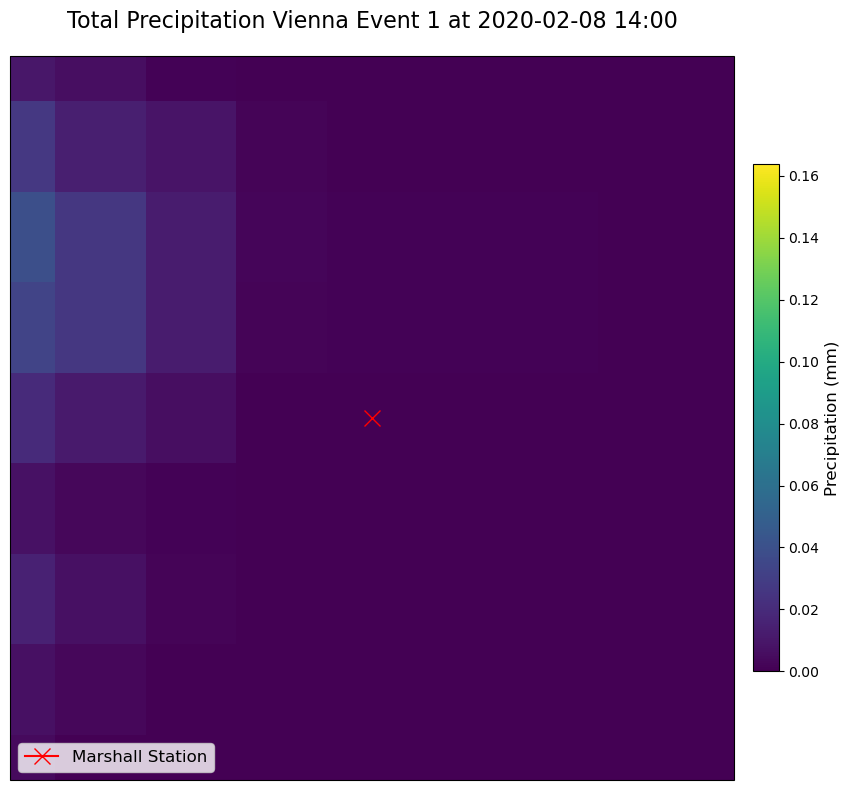

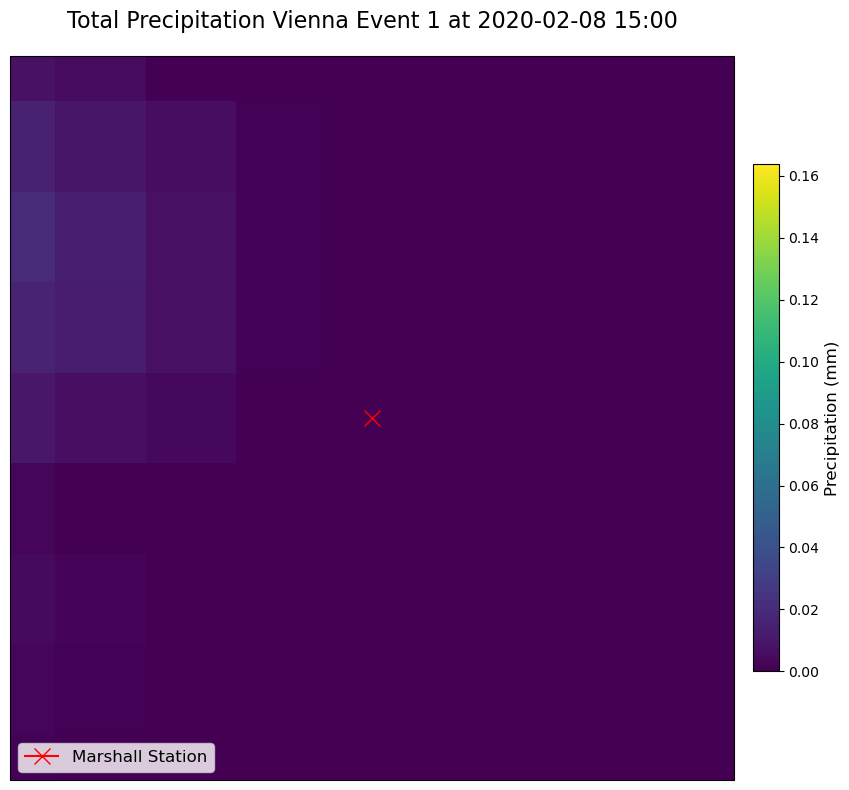

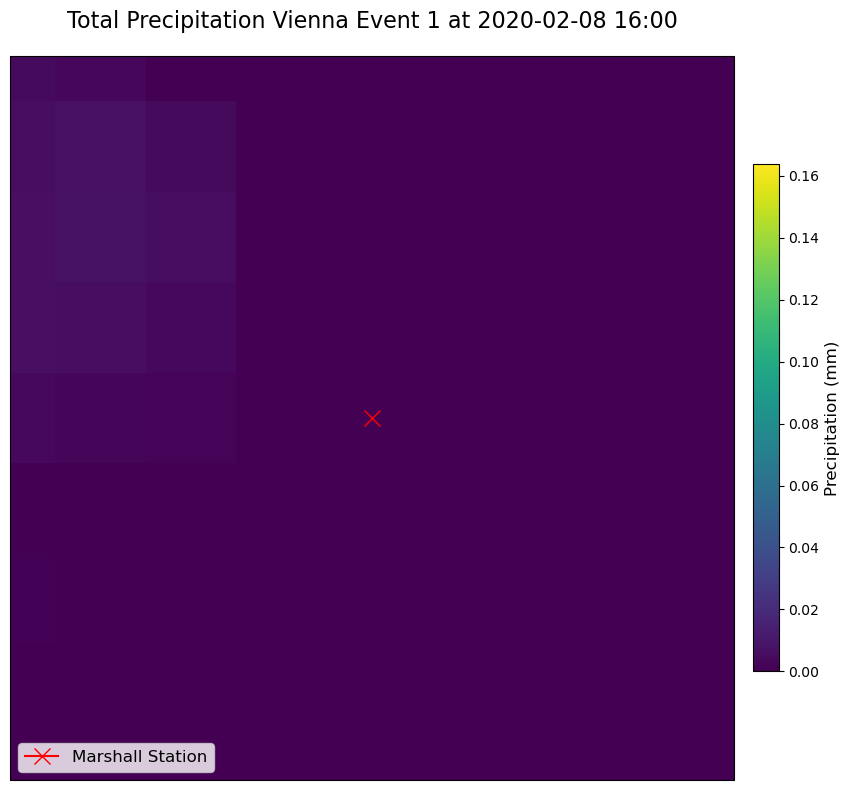

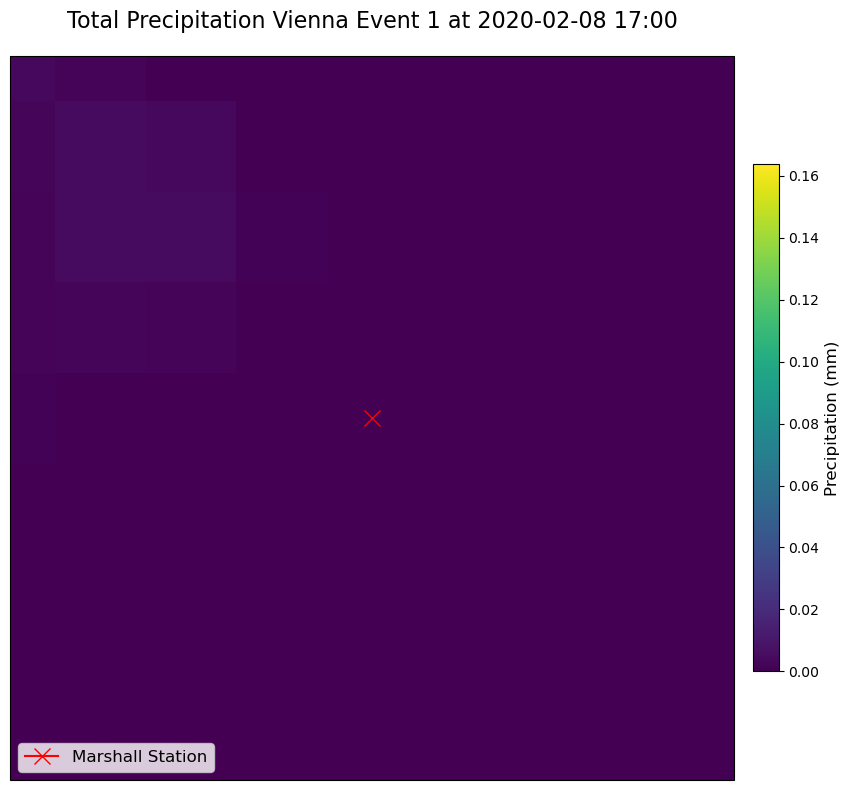

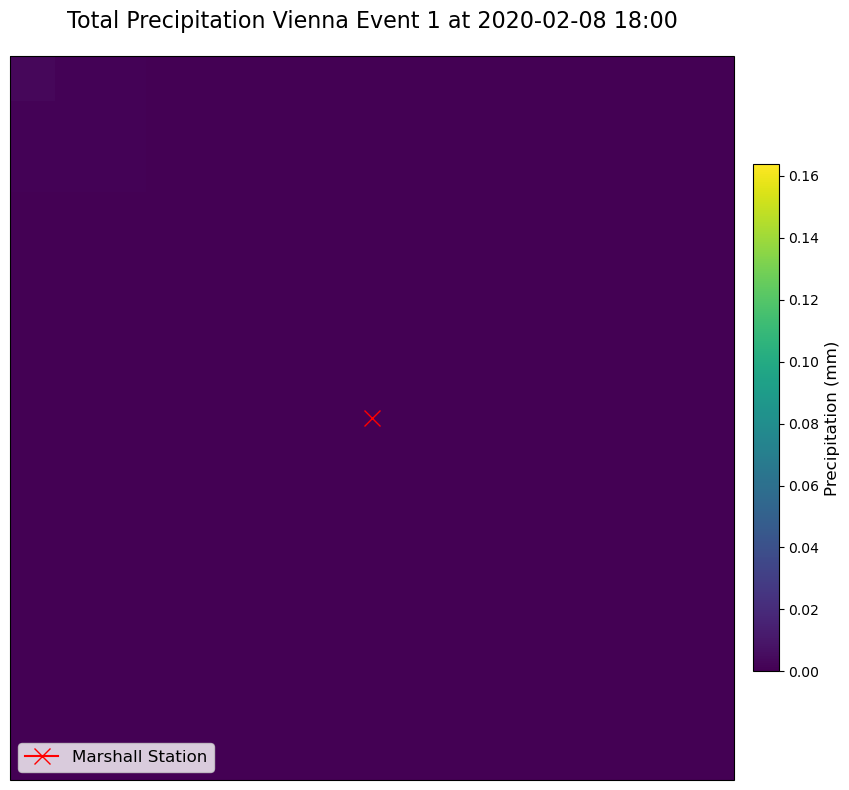

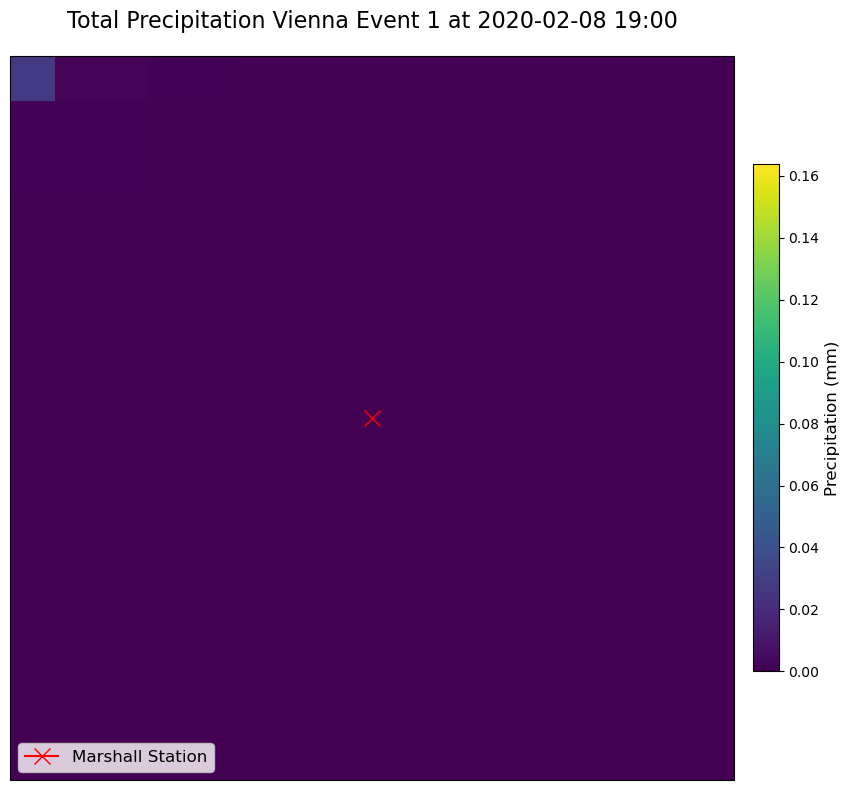

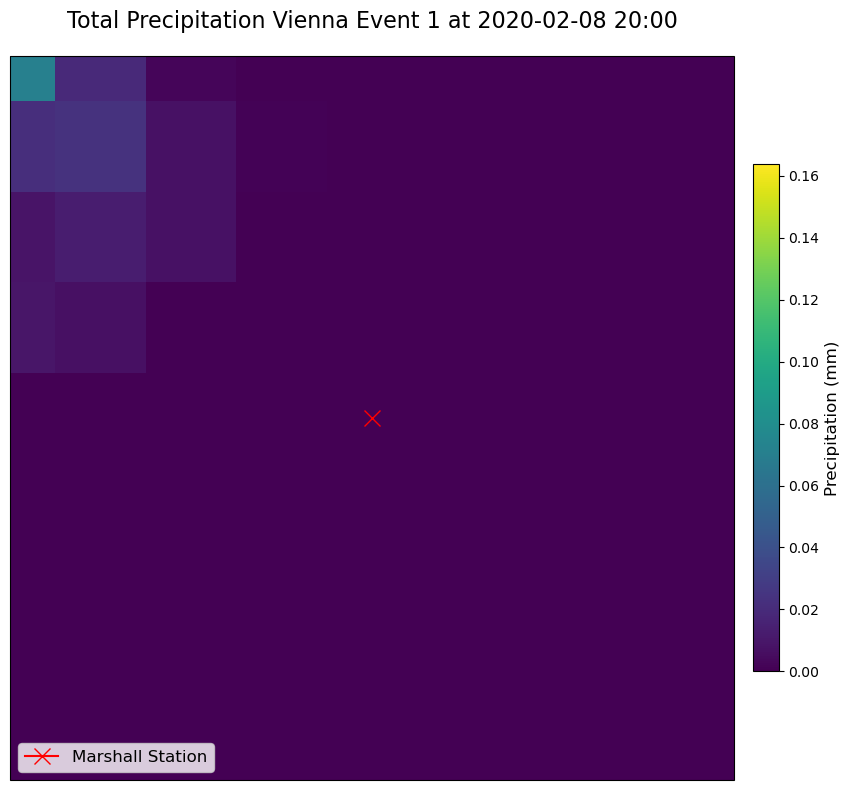

In [122]:
# Define the variable and coordinate names
var = 'tp'
lat = marshall_er5.lat.values
lon = marshall_er5.lon.values

# Coordinates of the specific point (Vienna Station)
point_lon = -105.196
point_lat = 39.9496 

# Select the time range
selected_data = marshall_er5.sel(time=slice("2020-02-08 12:00", "2020-02-08 20:00"))

# Create a meshgrid for pcolormesh
Lon, Lat = np.meshgrid(lon, lat)

# Define plot parameters
cmap = 'viridis'
vmin = selected_data[var].min().item()
vmax = selected_data[var].max().item()
title_base = 'Total Precipitation Vienna Event 1'

for t in selected_data.time:
    # Create a new figure with Cartopy's PlateCarree projection
    fig, ax = plt.subplots(
        figsize=(10, 8),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    
    # Extract data for the current time step
    data = selected_data[var].sel(time=t).values
    
    # Handle missing or invalid data
    data = np.ma.masked_invalid(data)
    
    # Plot the data using pcolormesh
    pcm = ax.pcolormesh(
        Lon, Lat, data, 
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree()
    )
        # Set the map extent based on data

    
    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)

    # Plot the specific point (Vienna Station)
    ax.plot(
        point_lon, point_lat,
        marker='x', color='red', markersize=12,
        transform=ccrs.PlateCarree(),
        label='Marshall Station'
    )

    extent = [lon.min(), lon.max(), lat.min(), lat.max()]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Add a colorbar
    cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.02, shrink=0.7)
    cbar.set_label('Precipitation (mm)', fontsize=12)
    
    # Set title with time information
    time_str = pd.to_datetime(t.values).strftime('%Y-%m-%d %H:%M')
    plt.title(f'{title_base} at {time_str}', fontsize=16, pad=20)
    
    # Add legend for the Vienna Station marker
    ax.legend(loc='lower left', fontsize=12)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Close the figure to free memory
    plt.close(fig)

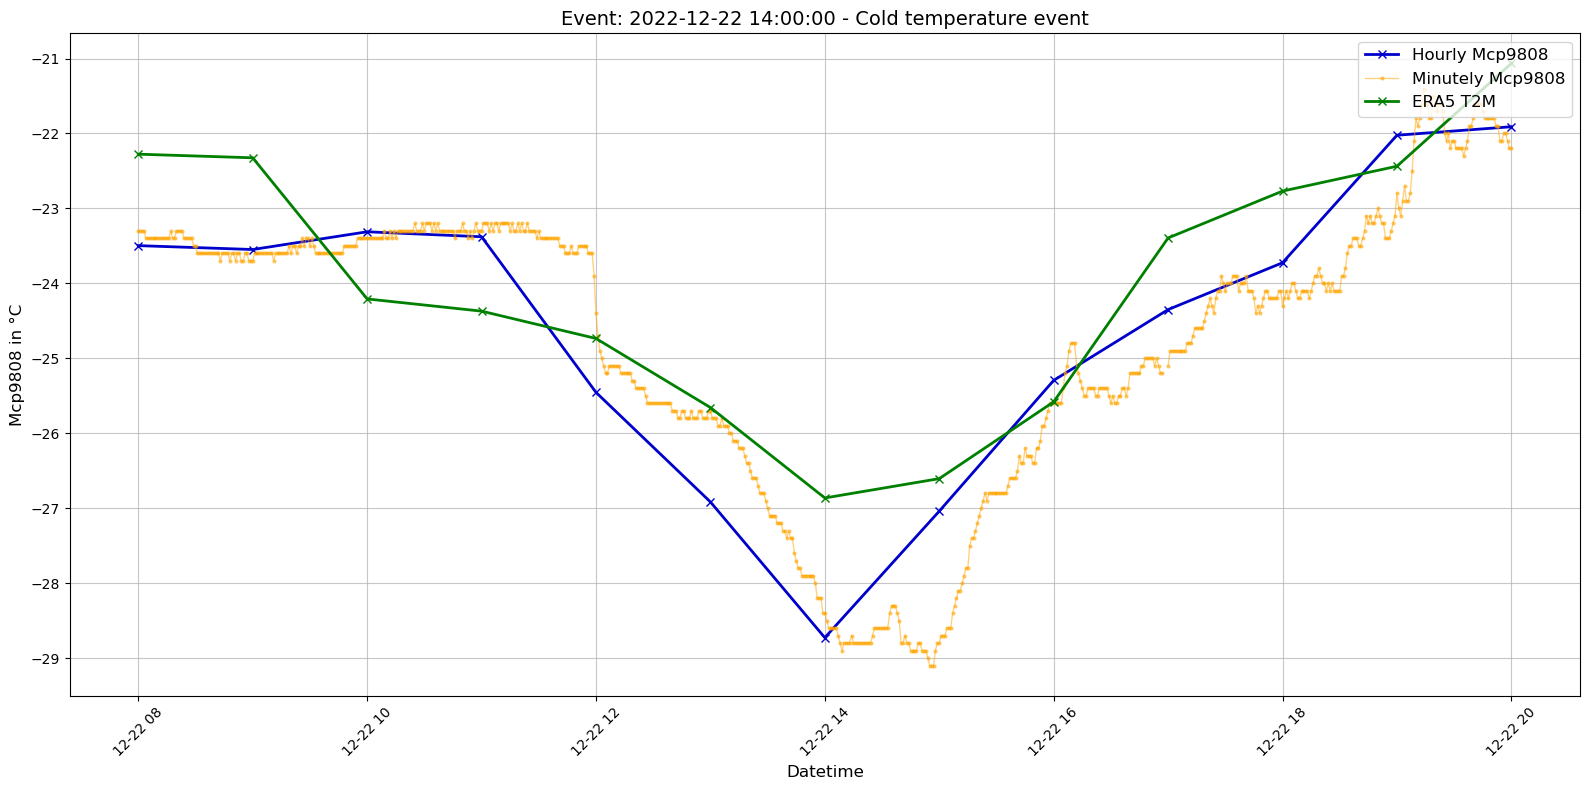

In [62]:
# Example Event 1
event_4 = pd.Timestamp("2022-12-22 14:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_4,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    era5_ds=marshall_er5,
    variable_hourly="mcp9808",       # Hourly temperature
    variable_minute="mcp9808",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=39.9496 ,
    lon=-105.196,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=True,
    title_suffix="Cold temperature event",
    save_fig=False
)

In [65]:
convert_grib_to_nc("era5_data/era5_marshall_events_220719.nc")
marshall_er5_220718 = xr.open_dataset("converted_era5_data/era5_marshall_events_220719.nc")

In [67]:
# Example Event 1
event_5 = pd.Timestamp("2022-07-18 18:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_er5_220718,
    era5_ds=marshall_er5,
    variable_hourly="mcp9808",       # Hourly temperature
    variable_minute="mcp9808",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=39.9496 ,
    lon=-105.196,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=True,
    title_suffix="High temperature event",
    save_fig=False
)

TypeError: can only lookup dictionaries from Dataset.loc

## Barbados


In [19]:
convert_grib_to_nc("era5_data/era5_barbados_events.nc")


In [20]:
barbados_er5 = xr.open_dataset("converted_era5_data/era5_barbados_events.nc")


In [196]:
print("Highest precip. value in ERA5:",barbados_er5.tp.values.max())
print("Highest temp. value in ERA5:",barbados_er5.t2m.values.max())
print("Highest wind speed value in ERA5:",barbados_er5.wind_speed.values.max())

Highest precip. value in ERA5: 19.318104
Highest temp. value in ERA5: 29.319366
Highest wind speed value in ERA5: 19.972046


In [23]:
barbados_processed_df = pd.read_csv("station_data_processed/barbados_hourly_processed_data.csv", index_col=0)
barbados_processed_df.index = pd.to_datetime(barbados_processed_df.index, errors='coerce')

# Apply the optimized aggregation
barbados_hourly_df = apply_aggregation(barbados_processed_df, aggregation_dict)

In [198]:
barbados_hourly_df.sort_values(by=['mcp9808'], ascending=True).head()


,bmp180_temp,bmp180_pres,bmp180_slp,bmp180_alt,bmp280_temp,bmp280_pres,bmp280_slp,bmp280_alt,bme_temp,bme_pres,bme_slp,bme_alt,bme_hum,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_dir,wind_speed
datetime,,,,,,,,,,,,,,,,,,,,,,
2022-07-26 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.4,0.0,NaN,NaN,NaN,NaN,NaN
2022-07-30 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,0.0,NaN,NaN,NaN,NaN,4.627241
2022-07-25 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.9,0.0,NaN,NaN,NaN,NaN,2.042167
2022-01-09 06:00:00,NaN,NaN,NaN,NaN,21.040,987.02,1018.745,NaN,NaN,NaN,NaN,NaN,NaN,19.4,98.2,19.8,5.4,260.0,253.5,NaN,NaN,5.219667
2022-01-09 07:00:00,NaN,NaN,NaN,NaN,21.135,986.64,1018.410,NaN,NaN,NaN,NaN,NaN,NaN,19.6,97.7,19.9,2.8,260.0,253.0,NaN,NaN,5.633000


In [199]:
event_1 = pd.Timestamp("2022-07-26 04:00")
time_delta = pd.Timedelta(hours=6)

filtered_df = barbados_hourly_df[(barbados_hourly_df.index >= event_1 - time_delta) & (barbados_hourly_df.index <= event_1 + time_delta)]
filtered_df

,bmp180_temp,bmp180_pres,bmp180_slp,bmp180_alt,bmp280_temp,bmp280_pres,bmp280_slp,bmp280_alt,bme_temp,bme_pres,bme_slp,bme_alt,bme_hum,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_dir,wind_speed
datetime,,,,,,,,,,,,,,,,,,,,,,
2022-07-25 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.516833
2022-07-25 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.182333
2022-07-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2022-07-26 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,NaN,NaN,NaN,NaN,0.023500
2022-07-26 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.116949
2022-07-26 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2022-07-26 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.4,0.0,NaN,NaN,NaN,NaN,NaN
2022-07-26 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2022-07-26 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


Wind speed:
- 2022-01-24 2:00:00 >50m/s

Precipitation: 
- 21.06.17 5  >60l
- 21.10.30 18 > 60l

Temperature: 
- cold: 22.07.26 04 <4°
- hot: 23.09.28 17  >30°

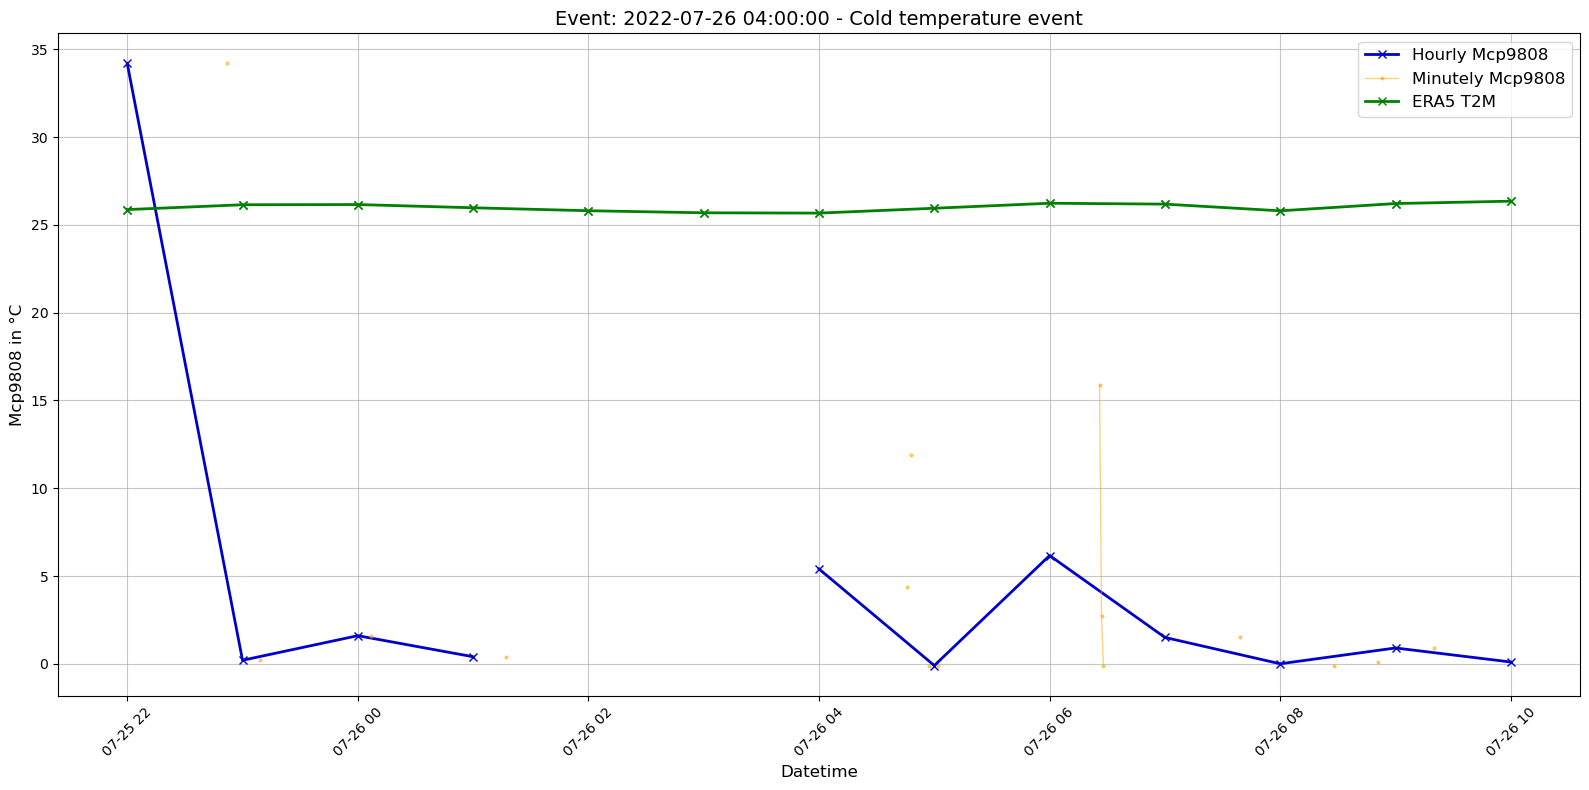

In [24]:
# Example Event 1
event_1 = pd.Timestamp("2022-07-26 04:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    era5_ds=barbados_er5,
    variable_hourly="mcp9808",       # Hourly temperature
    variable_minute="mcp9808",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=True,
    title_suffix="Cold temperature event",
    save_fig=False
)

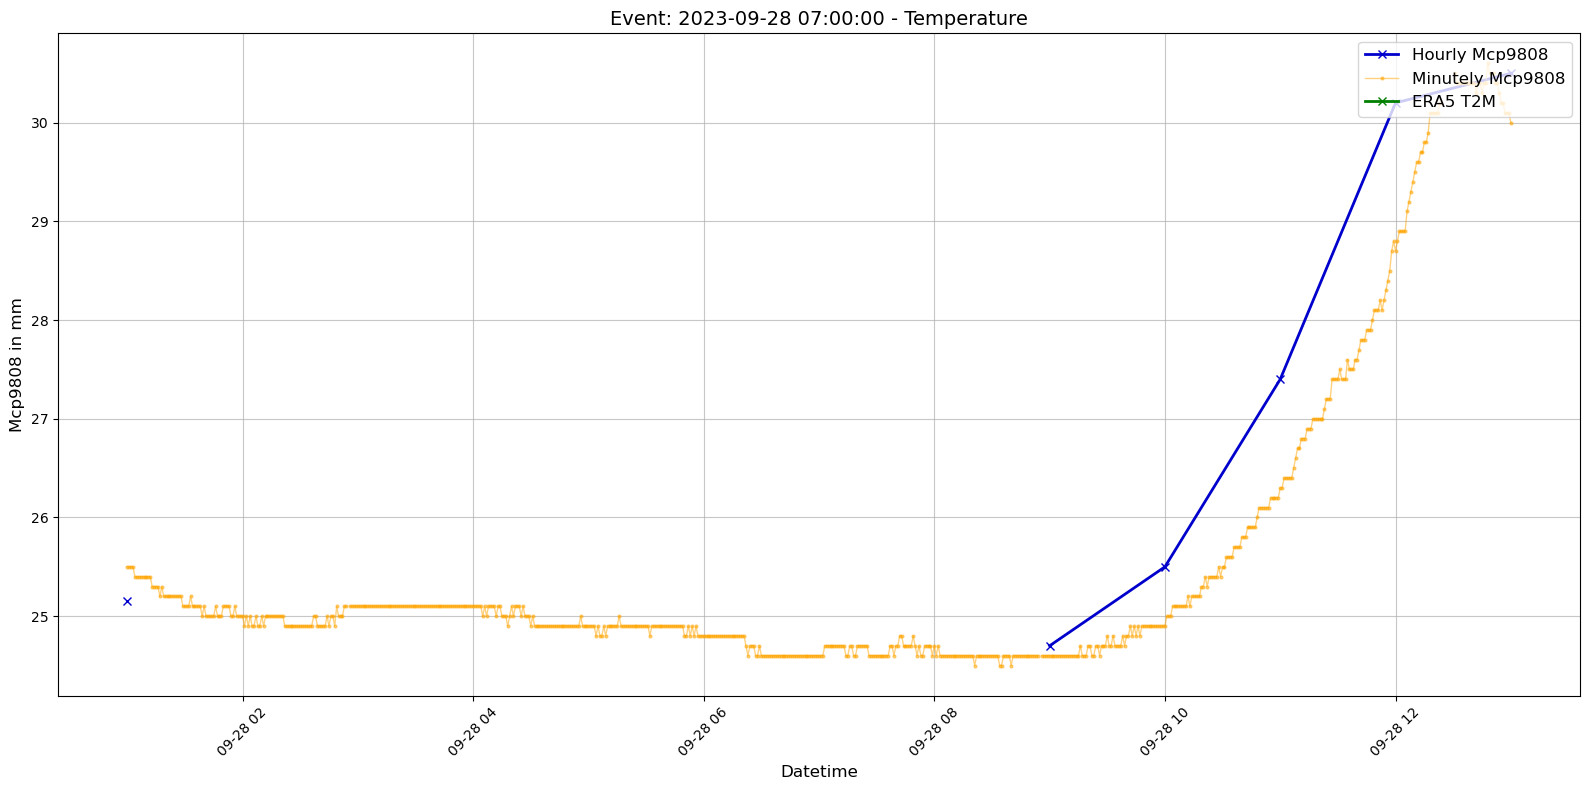

In [256]:
# Example Event 1
event_2 = pd.Timestamp("2023-09-28 07:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_2,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    era5_ds=barbados_er5,
    variable_hourly="mcp9808",       # Hourly temperature
    variable_minute="mcp9808",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=True,
    title_suffix="Temperature",
    save_fig=False
)

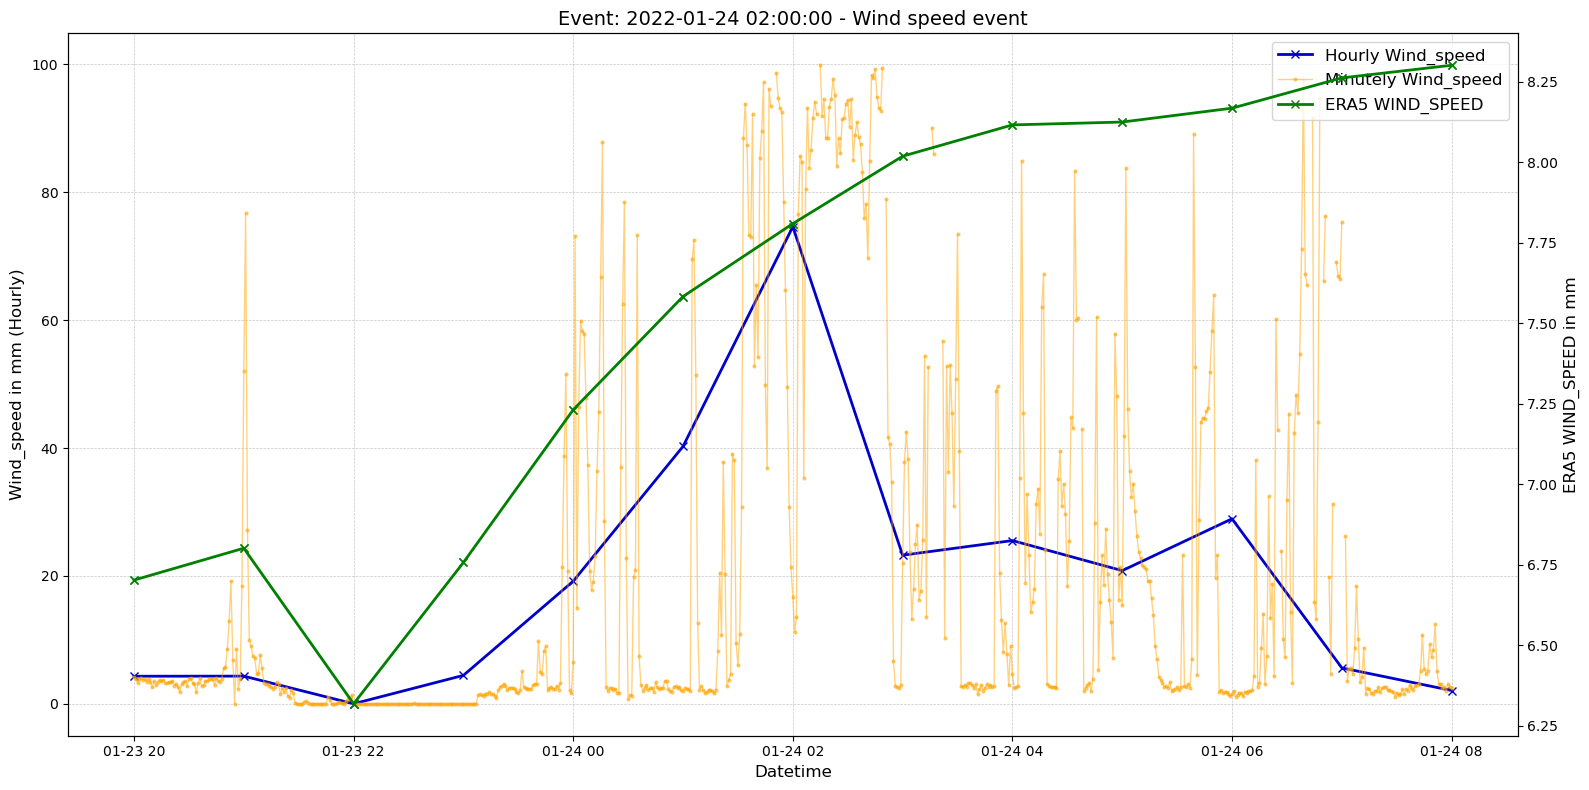

In [261]:
# Example Event 1
event_3 = pd.Timestamp("2022-01-24 02:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    era5_ds=barbados_er5,
    variable_hourly="wind_speed",       # Hourly temperature
    variable_minute="wind_speed",       # Minutely temperature
    era5_variable="wind_speed",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=False,
    title_suffix="Wind speed event",
    save_fig=False
)

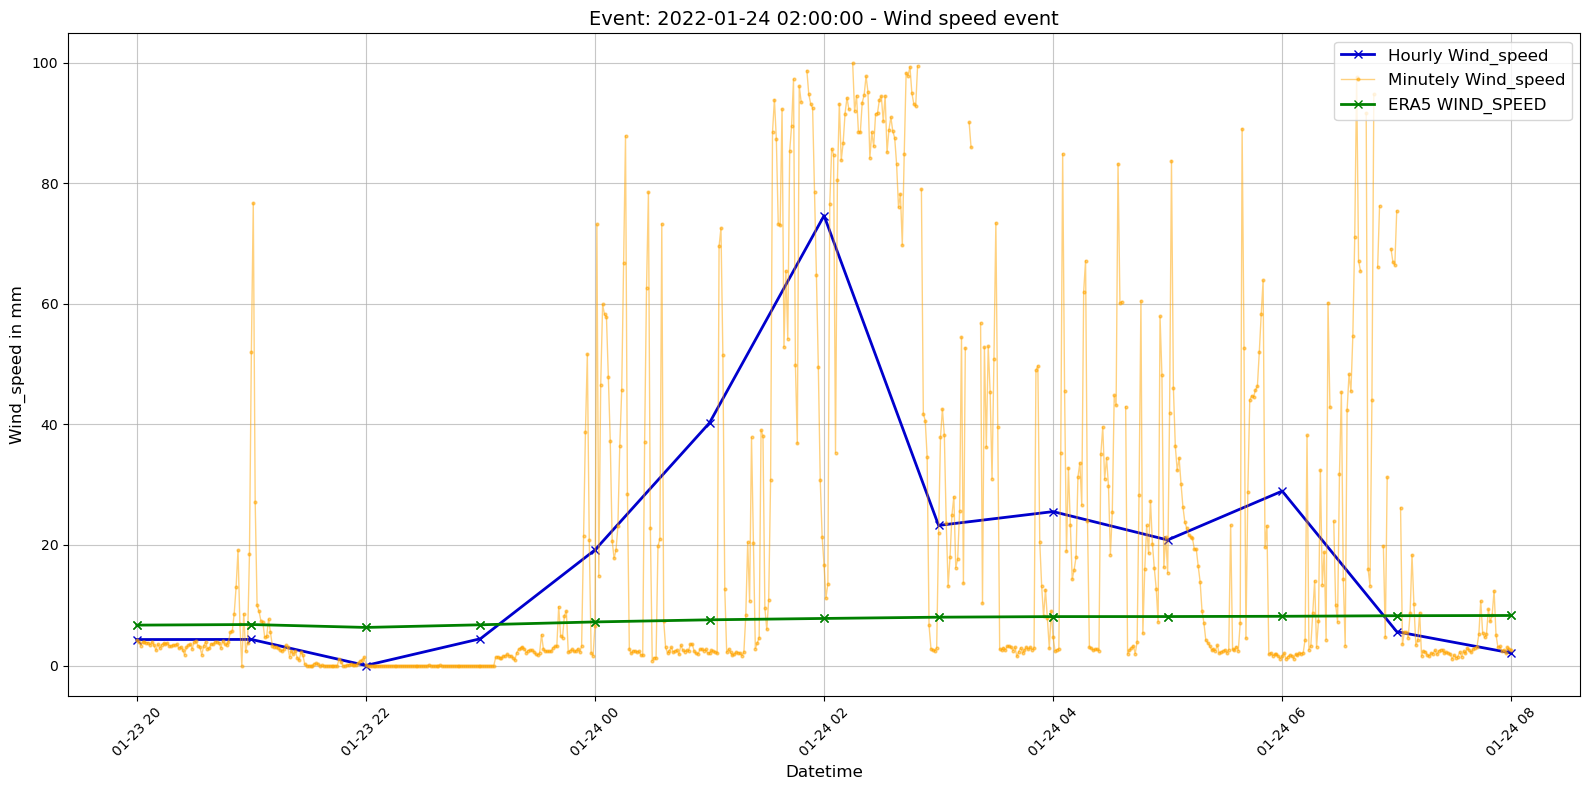

In [262]:
# Example Event 1
event_3 = pd.Timestamp("2022-01-24 02:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    era5_ds=barbados_er5,
    variable_hourly="wind_speed",       # Hourly temperature
    variable_minute="wind_speed",       # Minutely temperature
    era5_variable="wind_speed",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=True,
    title_suffix="Wind speed event",
    save_fig=False
)

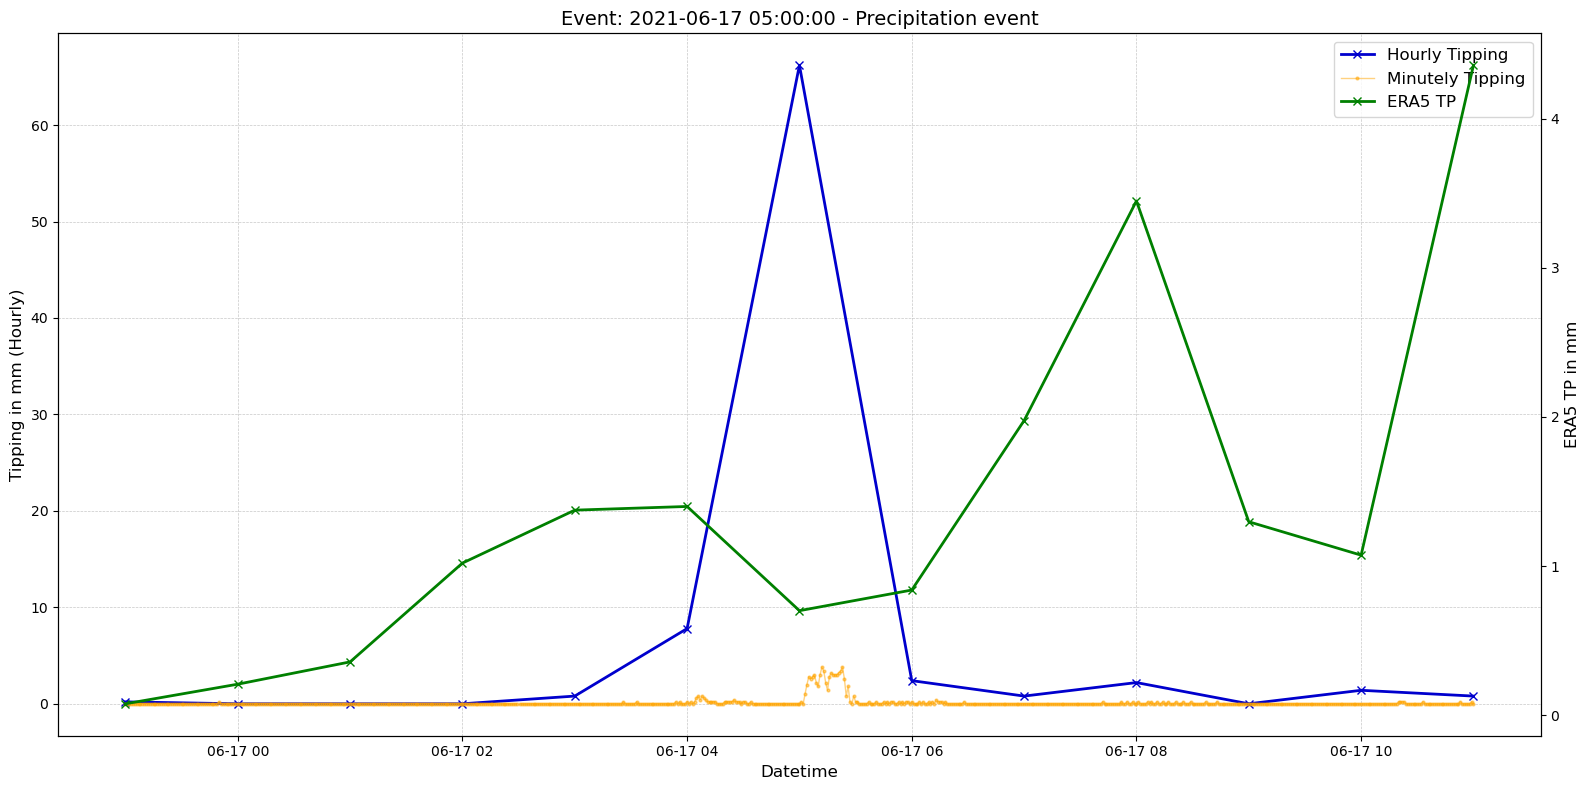

In [263]:
# Example Event 1
event_5 = pd.Timestamp("2021-06-17 05:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_5,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    era5_ds=barbados_er5,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=False,
    title_suffix="Precipitation event",
    save_fig=False
)

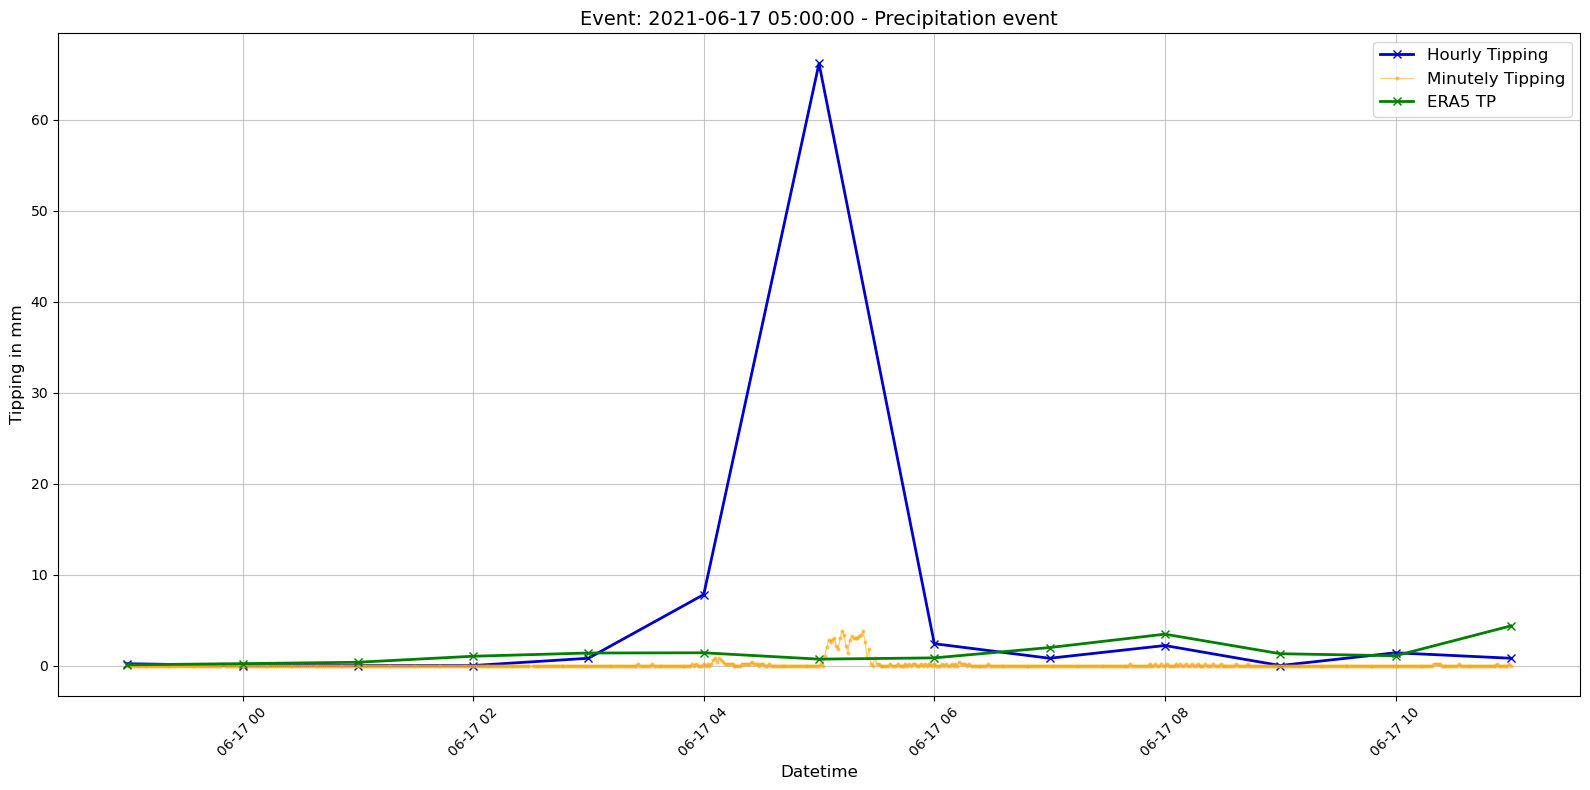

In [264]:
# Example Event 1
event_5 = pd.Timestamp("2021-06-17 05:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_5,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    era5_ds=barbados_er5,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=True,
    title_suffix="Precipitation event",
    save_fig=False
)

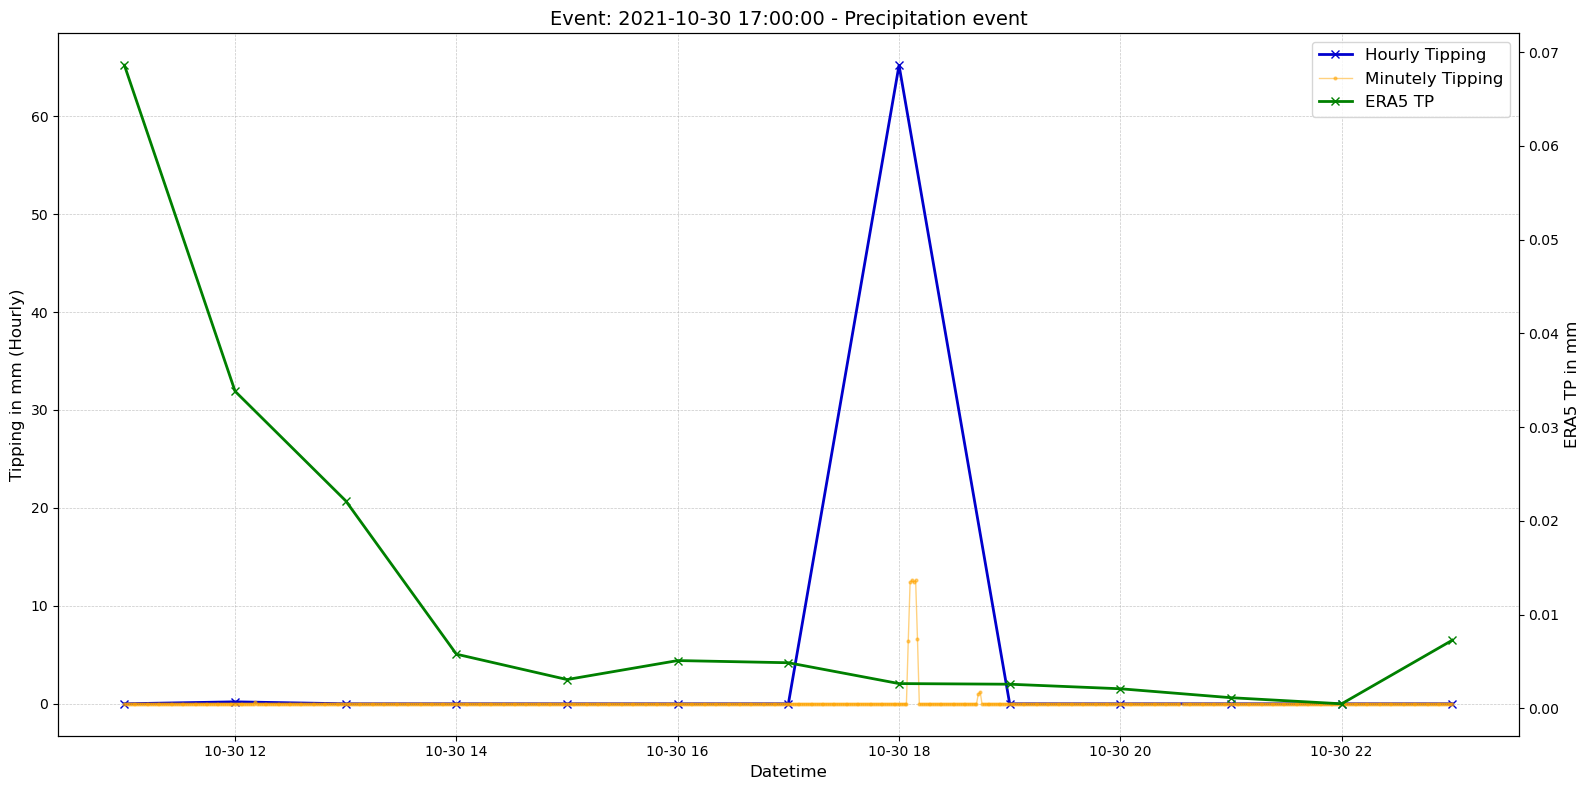

In [265]:
# Example Event 1
event_6 = pd.Timestamp("2021-10-30 17:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_6,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    era5_ds=barbados_er5,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=False,
    title_suffix="Precipitation event",
    save_fig=False
)

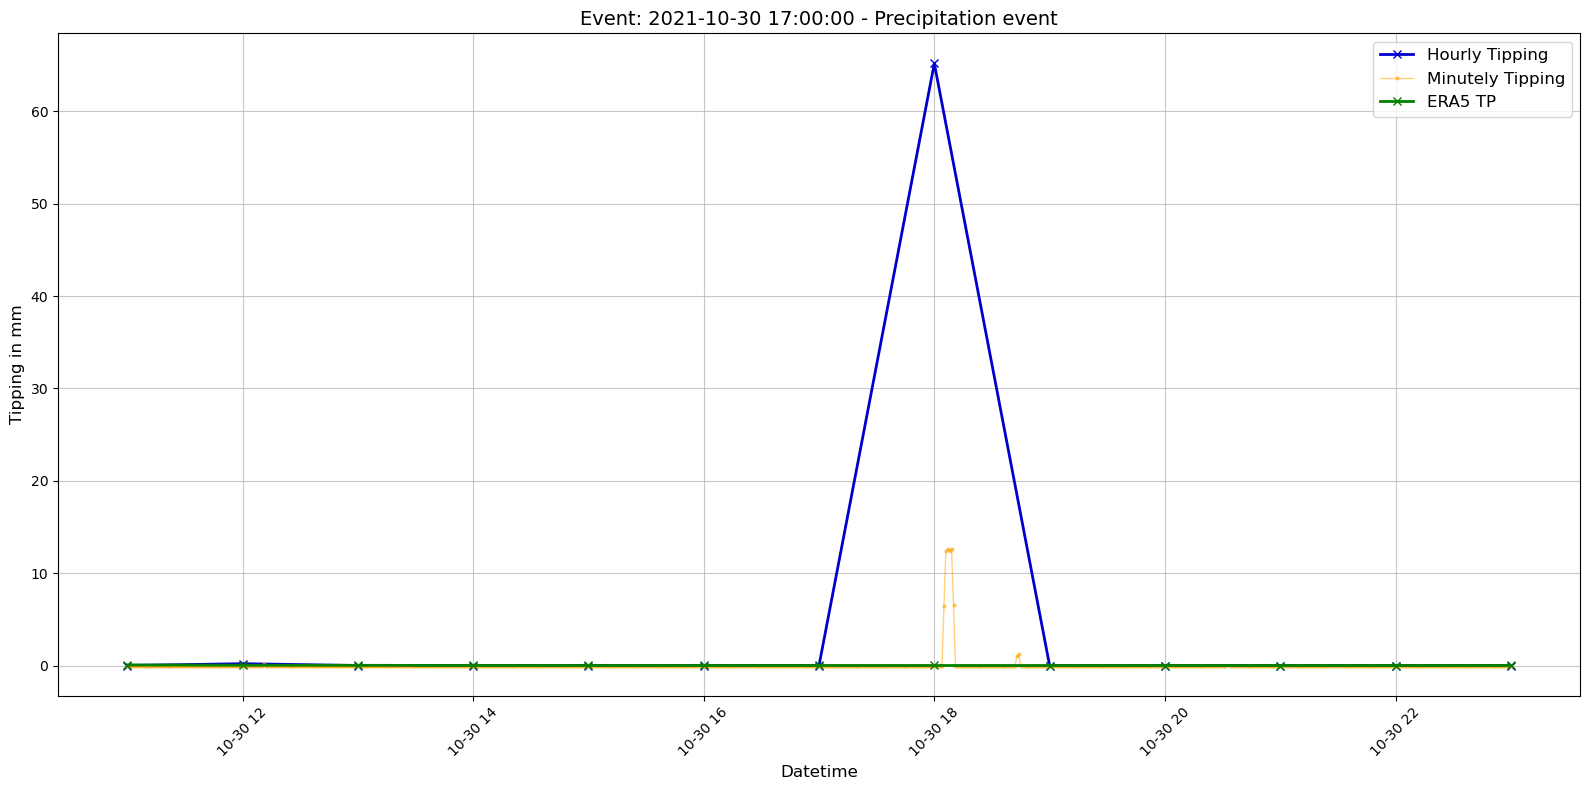

In [266]:
# Example Event 1
event_6 = pd.Timestamp("2021-10-30 17:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_6,
    hourly_df=barbados_hourly_df,
    minutely_df=barbados_processed_df,
    era5_ds=barbados_er5,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=True,
    title_suffix="Precipitation event",
    save_fig=False
)